# README

**The data**


The data that I am providing here is the following:
- A folder called 20_folders with the Pharokka output for 20 phages so you can see how the engineer_features function works and the whole pipeline below works (be careful if you save any files so that you do not overwrite the files mentioned below)
- An empty folder called output where everything you run here will be saved (to avoid such overwriting)
- A file called features_without_gram_class, which is the output from the engineer_features function applied to the whole 26k phages
- A file called features_with_gram_class, which is the same as the one above but after all the cleaning and the label assignation. This is the data used for fitting the models
- The mash distances computed on features_with_gram_class, which are used to run NetworkX
- Two files for Gram staining assignation called "all_gram_stains_fixed_species.csv" and "updated_gram_pos_neg_dict.pkl". The reason I have two files is because, even though the updated dict has all the information to perform the labeling, I have not bothered to change the code to just use that, so I still use of the first csv files that I generated through the project. Messy but it works
- The best random forest model saved in two files: random_forest.pkl and scaler_random_forest.pkl 
- A csv file with the predictions on the discarded dataset made with that model.


The data that I provide is enough to run everything without ever needing to save any output yourself. However, in any case, if you run the notebook all of the data that you have in data/ (and more) will be generated and stored in the output/ folder. The only exception is "features_without_gram_class.csv", which needs the full pharokka output. This means that from point number 2) you are actually running the real thing and not a small subset of the data like you do in point 1).

**This notebook**

The code starts the processing of the data immediately after obtaining the output from Pharokka

**The environment**

There is a text file with a list of *all* the packages that I have in my conda environment. Not all of them are required for this run, but many are. So I don't know, you can either just install them all in a conda environment or just install packages as you need them

**TODO** 
- use lightgbm instead of random forest
- divide the data into training, testing and validation
- feature reduction (plot number of features vs mcc on validation)
- test without “non-neutral” features (protein function predictions)
- settle on a final model
- predict on different trashed data individually, Archaea, variable gram staining etc.
- predict on 1 million phage genomes (Bent wil run pharokka on them now)
- write the paper 


In [ ]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation
from Bio.Seq import UndefinedSequenceError
import argparse
import os
import subprocess
import numpy as np
import random
random.seed(42)

# 1. Feature Engineering

In [3]:
def engineer_features(folder):
    # Read data from the TSV file


    # Initialize lists for storing data
    ids = []
    topologies = []
    sequences = []

    # Read the GenBank file for topology and sequences
    genbank_file = f'{folder}/pharokka.gbk'
    for record in SeqIO.parse(genbank_file, "genbank"):
        ids.append(record.id)    
        topologies.append(record.annotations.get('topology', 'N/A'))
        sequences.append(str(record.seq))

    # Read data from the TSV file

    df = pd.read_csv("data/8Sep2023_vConTACT2_host_annotations.tsv", sep = "\t")

    df = df.rename(columns={
        "Node_ID": "id_inphared",
        "Description": "isolation_host_inphared",
        "Host": "host_inphared"
    })

    df = df[df['id_inphared'].isin(ids)]

    # Create DataFrames from the topologies and sequences
    topology_df = pd.DataFrame({'id_inphared': ids, 'topology': topologies})
    sequence_df = pd.DataFrame({'id_inphared': ids, 'sequence': sequences})

    # Merge the TSV data with the GenBank topology and sequence data
    df = pd.merge(df, topology_df, on='id_inphared', how='left')
    df = pd.merge(df, sequence_df, on='id_inphared', how='left')
    del(topology_df)
    del(sequence_df)

    df = pd.get_dummies(df, columns=['topology'])


    df_length_gc_cds_density = pd.read_csv(f"{folder}/pharokka_length_gc_cds_density.tsv", sep="\t")
    df_length_gc_cds_density['contig'] = df_length_gc_cds_density['contig'].str.slice(0,8)
    df_length_gc_cds_density


    df = pd.merge(df, df_length_gc_cds_density, left_on='id_inphared', right_on='contig', how='outer')
    del(df_length_gc_cds_density)

    df_cds = pd.read_csv(f"{folder}/pharokka_cds_functions.tsv", sep="\t")
    
    # Define a dictionary of replacements
    replacements = {
        "DNA, RNA and nucleotide metabolism":"nucleotide_metabolism",
        "head and packaging": "head_packaging",
        "moron, auxiliary metabolic gene and host takeover": "host_takeover",
        "transcription regulation": "transcription",
        "unknown function": "unkown_function"
    }

    # Replace the values using the dictionary
    df_cds['Description'] = df_cds['Description'].replace(replacements)

    df_cds = df_cds.pivot(index='contig', columns='Description', values='Count').reset_index()
    df_cds['contig'] = df_cds['contig'].str.slice(0,8)

    df = pd.merge(df, df_cds, left_on='id_inphared', right_on='contig', how='outer')
    del(df_cds)


    df_frame = pd.read_csv(f"{folder}/pharokka_cds_final_merged_output.tsv", sep="\t",  low_memory=False)

    frame_counts = df_frame.groupby('contig')['frame'].value_counts().unstack(fill_value=0)

    # Ensure both '+' and '-' columns are present
    frame_counts['+'] = frame_counts.get('+', 0)
    frame_counts['-'] = frame_counts.get('-', 0)

    # Rename columns explicitly
    frame_counts = frame_counts.rename(columns={'+': 'frame_positive', '-': 'frame_negative'})

    # Reset index if needed
    frame_counts = frame_counts.reset_index()
    frame_counts = frame_counts.rename_axis(None, axis=1).reset_index()
    frame_counts['contig'] = frame_counts['contig'].str.slice(0,8)
    df = pd.merge(df, frame_counts, left_on='id_inphared', right_on='contig', how='outer')

    df['jumbophage'] = df['length'].apply(lambda x: x >= 200000)
    df['jumbophage'] = df['jumbophage'].astype(int)  # Convert True/False to 1/0
    


    df = df.rename(columns={'id_inphared': 'id'})
    df['dummy_index'] = 0

    # Group by the dummy index and aggregate using 'first'
    df = df.groupby('dummy_index').first()
    # Creating new manual features
    df['positive_strand_%'] = round(df['frame_positive'] / df['CDS'] * 100,2)
    df['negative_strand_%'] = round(df['frame_negative'] / df['CDS'] * 100,2)


    # Reset the index
    df = df.reset_index(drop=True)

    columns = ['id','host_inphared','isolation_host_inphared','length', 'jumbophage', 'gc_perc',
        'CDS','frame_positive', 'frame_negative', 'cds_coding_density',  'positive_strand_%',
        "negative_strand_%",'CARD_AMR_Genes', 'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'transl_table', 'sequence']
    
    df = df[columns]
    return df


In [4]:
# Code to generate features of the phages in a given folder 
def process_pharokka_output(args_data, output_csv):
    # Check if output CSV file exists, if not create it
    if not os.path.exists(output_csv):
        with open(output_csv, 'w') as f:
            pass

    # Iterate over each folder in the main folder
    for folder in os.listdir(args_data):
        folder_path = os.path.join(args_data, folder)

        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Check if "pharokka.gbk" file exists in the folder
            if "pharokka.gbk" in os.listdir(folder_path):
                print(f"Processing {folder_path}...")

                df = engineer_features(folder_path)

                # Append the dataframe to the CSV file
                with open(output_csv, 'a') as f:
                    df.to_csv(f, header=f.tell()==0, index=False)
            else:
                print(f"Skipped {folder_path}: 'pharokka.gbk' file not found or not a directory")

args_data = 'data/pharokka_full_output/' 
output_csv = 'output/features_without_gram.csv'

print("-> Starting Feature Engineering ----------------------")

# Delete the output CSV file if it already exists
if os.path.exists(output_csv):
    print("Output file already exists. Overwriting it...")
    os.remove(output_csv)
    
if os.path.isdir(args_data):
    print(f"Processing Pharokka phages in directory: {args_data}")
    process_pharokka_output(args_data, output_csv)


print(f"Feature engineering completed and data stored to CSV in {output_csv}.")

-> Starting Feature Engineering ----------------------
Processing Pharokka phages in directory: data/20_folders/
Processing data/20_folders/sequence_066.fasta.pharokka...
Processing data/20_folders/sequence_067.fasta.pharokka...
Processing data/20_folders/sequence_068.fasta.pharokka...
Processing data/20_folders/sequence_069.fasta.pharokka...
Processing data/20_folders/sequence_070.fasta.pharokka...
Processing data/20_folders/sequence_16443.fasta.pharokka...
Processing data/20_folders/sequence_16444.fasta.pharokka...
Processing data/20_folders/sequence_16445.fasta.pharokka...
Processing data/20_folders/sequence_16446.fasta.pharokka...
Processing data/20_folders/sequence_16447.fasta.pharokka...
Processing data/20_folders/sequence_16448.fasta.pharokka...
Processing data/20_folders/sequence_16449.fasta.pharokka...
Processing data/20_folders/sequence_16450.fasta.pharokka...
Processing data/20_folders/sequence_16451.fasta.pharokka...
Processing data/20_folders/sequence_16452.fasta.pharokka.

# 2. Filtering out unwanted sequences of training

In [5]:
import pickle
import pandas as pd

In [5]:
# Removing weird names
df = pd.read_csv('data/features_without_gram_class.csv')
print("Shape before filtering", df.shape)
print(df.columns)

# Saving discarded phages in csv
discarded = df[(df['host_inphared'] == 'Unspecified') | (df['isolation_host_inphared'] == 'Unspecified')]

df = df[df['host_inphared'] != "Unspecified"] 
print("Shape after filtering unspecified hosts", df.shape)
df = df[df['isolation_host_inphared'] != "Unspecified"]
print("Shape after filtering unspecified isolation hosts", df.shape)

# Only keep first two strings in each row of Isolation Host to reduce name incompatibilities
# Split each value on space and select the first two elements
df['isolation_host_inphared'] = df['isolation_host_inphared'].str.split().str[:2].str.join(' ')

# Fixing mispelled genera, wrong taxonomy, etc
df['host_inphared'] = df['host_inphared'].replace('Enteroccous', 'Enterococcus')
df.loc[df['isolation_host_inphared'] == 'Salmonella enterica', 'host_inphared'] = 'Salmonella'
df.loc[df['isolation_host_inphared'] == 'Salmonella typhimurium', 'host_inphared'] = 'Salmonella'
df.loc[df['isolation_host_inphared'] == 'Escherichia coli', 'host_inphared'] = 'Escherichia'
df.loc[df['isolation_host_inphared'] == 'E. coli', 'host_inphared'] = 'Escherichia'
df.loc[df['isolation_host_inphared'] == 'Escherichia coli,', 'host_inphared'] = 'Escherichia'
df.loc[df['isolation_host_inphared'] == 'Shigella flexneri', 'host_inphared'] = 'Shigella'

Shape before filtering (26286, 42)
Index(['id', 'host_inphared', 'isolation_host_inphared',
       'genome_length_inphared', 'gc_%_inphared', 'cds_number_inphared',
       'positive_strand_%_inphared', 'negative_strand_%_inphared',
       'coding_capacity_inphared', 'tRNAs_inphared', 'host_inphared.1',
       'isolation_host_inphared.1', 'molecule_inphared_type_DNA',
       'topology_linear', 'jumbophage_inphared', 'topology_circular',
       'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_RNA',
       'molecule_inphared_type_ss-RNA', 'length', 'gc_perc', 'transl_table',
       'cds_coding_density', 'CARD_AMR_Genes', 'CDS', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative',
       'sequence'],
      dtype='object')
Shape after filtering unspecified 

# 3. Gram Assignation

In [6]:
print("-> Starting Gram Staining Assignation ----------------------")
# Excluding genera and species with unclear gram staining
exclude_genus = ['Clostridium', 'Neobacillus', 'Alteribacter', 'Desulfotomaculum', 'Caloramator', 'Desulforamulus', 'Heyndrickxia', 'Peptoclostridium', 'Thermoanaerobacter', 'Thermoanaerobacterium', 'Aureimonas', 'Actinomadura', 'Alkalibacterium', 'Deinococcus', 'Tepidibacillus', 'Sphingomonas', 'Lysinibacillus', 'Ruminiclostridium', 'Caldicellulosiruptor', 'Pseudomonas', 'Streptococcus', 'Microlunatus', 'Streptomyces', 'Butyricimonas', 'Halalkalibacter', 'Chelativorans', 'Natrinema', 'Ureibacillus', 'Clostridioides', 'Desulfosporosinus', 'Lacibacter', 'Nocardioides', 'Siminovitchia', 'Belliella', 'Tistlia', 'Actinoplanes', 'Paenibacillus', 'Vallitalea', 'Actinotalea', 'Cohnella', 'Rhizobium', 'Anaerotignum', 'Cellulomonas', 'Flavobacterium', 'Bacillus', 'Nesterenkonia']
exclude_species = ['Ureibacillus massiliensis', 'Tistlia consotensis', 'Clostridioides difficile', 'Vallitalea guaymasensis', 'Belliella pelovolcani', 'Actinotalea ferrariae']

# Save the discarded dataframe
excluded_rows = df[df['host_inphared'].isin(exclude_genus) | df['isolation_host_inphared'].isin(exclude_species)]

# Append the excluded rows to the discarded DataFrame
discarded = pd.concat([discarded, excluded_rows], ignore_index=True)
del(excluded_rows)

print("Shape of the dataframe before deleting the unclear genera: ", df.shape)
df = df[~df['host_inphared'].isin(exclude_genus)]
print("Shape of the dataframe after deleting the unclear genera: ", df.shape)
df = df[~df['isolation_host_inphared'].isin(exclude_species)]
shape1 = df.shape
print("Shape of the dataframe after deleting the unclear species: ", shape1)


# Loading default gram staining mapping
all_gram = pd.read_csv("data/all_gram_stains_fixed_species.csv")
print("All gram shape, ",all_gram.shape)

# First mapping: from Species to Isolation host
# Create a mapping dictionary from species to Gram stain
species_to_stain = dict(zip(all_gram['species'], all_gram['Gram stain']))


# Use the mapping to create the 'staining' column in df
df['staining'] = df['isolation_host_inphared'].map(species_to_stain)
print(df.shape)
drop = df.dropna(subset=['staining'])
shape2 = drop.shape

print("Percentage of phages assigned a class based solely on species: ", str(shape2[0]/shape1[0]*100))

# Second mapping: From Genus to Host 
genus_to_stain = dict(zip(all_gram['Genus'], all_gram['Gram stain']))

# Use the mapping to create the 'staining' column in df
df['staining'] = df['host_inphared'].map(genus_to_stain)
print(df.shape)
drop = df.dropna(subset=['staining'])
shape3 = drop.shape
print(shape3)
print("Percentage of phages assigned a class using species+genus: ", str(shape3[0]/shape1[0]*100))

# Remaining phages which are unmapped
remaining = df[(df["staining"] != "positive") & (df["staining"] != "negative")]
print("The number of unclassified phages in this first round of mapping is", remaining.shape[0])

with open('data/updated_gram_pos_neg_dict.pkl', 'rb') as file:
    phage_dict = pickle.load(file)

file.close()

# Create a new genus_to_stain with updated values
phage_dict = {key: 'negative' if value == 'neg' else 'positive' for key, value in phage_dict.items()}

# Iterate through the DataFrame
for index, row in df.iterrows():
    if pd.isna(row['staining']):  # Check if 'staining' column is NaN
        host = row['host_inphared']
        if host in phage_dict:
            df.at[index, 'staining'] = phage_dict[host]

drop = df.dropna(subset=['staining'])
shape4 = drop.shape
print("Percentage of phages assigned a class using species+genus+extra dict: ", str(shape4[0]/shape1[0]*100))

if str(shape4[0]/shape1[0]*100) != "100.0":
    print("The number of unclassified phage Hosts is",len(remaining["host_inphared"].unique().tolist()))
    print("The unclassified Hosts are:",remaining["host_inphared"].unique().tolist())
    print()
    print("The number of unclassified phage Iolation Hosts is",len(remaining["isolation_host_inphared"].unique().tolist()))
    print("The unclassified Isolation Hosts are:",remaining["isolation_host_inphared"].unique().tolist())

else:
    print("All input phages have been successfully assigned a Gram staining class.")

del(remaining)

# Step 1: Replace NaN values with "remove"
df['staining'].fillna('remove', inplace=True)

# Step 2: Separate removed rows and update df_mapped
removed = df[df['staining'] == "remove"]
print("Number of entries removed due to NaN in staining", removed.shape)
df = df[df['staining'] != "remove"]
print(df.shape)

# Calculate the percentage of removed phages
print("Percentage of phages removed due to unclear genera in the last step: ", str(removed.shape[0] / shape1[0] * 100))

# Step 3: Append the removed rows to the discarded DataFrame
# Assuming discarded is defined earlier in your code
discarded = pd.concat([discarded, removed.drop('staining', axis=1)], ignore_index=True)

discarded_output = 'output/discarded.csv'

# Delete the output CSV file if it already exists
if os.path.exists(discarded_output):
    os.remove(discarded_output)

print(f"{discarded[discarded.isna().any(axis=1)].shape[0]} unclassified phages have not been stored in the discarded dataframe because they contained null values. ")
discarded.dropna(inplace=True)
print(f"Saving discarded data into a csv in {discarded_output}...")
discarded.to_csv(discarded_output,  index=False)

-> Starting Gram Staining Assignation ----------------------
Shape of the dataframe before deleting the unclear genera:  (14416, 42)
Shape of the dataframe after deleting the unclear genera:  (11467, 42)
Shape of the dataframe after deleting the unclear species:  (11467, 42)
All gram shape,  (7541, 3)
(11467, 43)
Percentage of phages assigned a class based solely on species:  22.17668091043865
(11467, 43)
(9495, 43)
Percentage of phages assigned a class using species+genus:  82.80282549925874
The number of unclassified phages in this first round of mapping is 1972
Percentage of phages assigned a class using species+genus+extra dict:  97.17450074125752
The number of unclassified phage Hosts is 86
The unclassified Hosts are: ['Salmonella', 'Spiroplasma', 'Brochothrix', 'Synechococcus', 'Pelagibacter', 'Plectonema', 'Verrucomicrobia', 'Microcystis', 'Sulfolobus', 'Cedecea', 'Janthinobacterium', 'Elizabethkingia', 'Citromicrobium', 'Kurthia', 'Liberibacter', 'Sphaerotilus', 'Lokiarchaeota'

In [7]:
# Code to save the features with the Gram Class assignation
# Removing Host and Isolation Host
df = df[['id', 'staining', 'length',
       'jumbophage', 'gc_perc', 'CDS', 'frame_positive', 'frame_negative',
       'cds_coding_density', 'positive_strand_%', 'negative_strand_%',
       'CARD_AMR_Genes', 'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'transl_table', 'sequence']]


stain_output = "output/features_with_gram_class.csv"
df.to_csv(stain_output, index=False)
print(f"---Gram staining assignation has been completed, and the data is stored in {stain_output}")

---Gram staining assignation has been completed, and the data is stored in output/features_with_gram_class.csv


# 4. Machine Learning

In [8]:
import pandas as pd
import warnings

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, f1_score, log_loss,
    mean_squared_error, accuracy_score,
    balanced_accuracy_score, classification_report,
    matthews_corrcoef
)
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score,  log_loss, mean_squared_error, balanced_accuracy_score
from math import sqrt
import os
import subprocess
import shutil
from concurrent.futures import ProcessPoolExecutor, as_completed
import networkx as nx
from networkx.algorithms import community
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from networkx.algorithms import community
import networkx as nx

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, log_loss, 
                             mean_squared_error, f1_score, matthews_corrcoef, 
                             roc_curve, precision_recall_curve, auc, confusion_matrix)
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient and other metrics.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = len([x for x in y_true if x == 1])
    N = len([x for x in y_true if x == 0])

    Tp, Fp = 0, 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1: Tp += 1
        elif y_true[i] == 0 and y_pred[i] == 1: Fp += 1

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt(
            (Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return (mcc, f" \n \
    P: {P:_} \n \
    Tp: {Tp:_} \n \
    Fp: {Fp:_} \n \
    N: {N:_} \n \
    Tn: {Tn:_} \n \
    Fn: {Fn:_}")

## 4.1 Statistics

In [9]:
# Data for stats
df = pd.read_csv("../data/test/features_with_gram_class.csv")

df = df[['staining', 'length', 'jumbophage', 'gc_perc', 'CDS',
       'frame_positive', 'frame_negative', 'cds_coding_density',
       'positive_strand_%', 'negative_strand_%', 'CARD_AMR_Genes', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'transl_table']]


df['staining'] = df['staining'].replace({'negative': 0, 'positive': 1})

stats = df.describe(percentiles=[0.5])
stats = stats.transpose()
stats = stats[['mean', 'std', 'min', '50%', 'max']]
stats = stats.round(2)
stats

,mean,std,min,50%,max
staining,0.29,0.45,0.00,0.00,1.00
genome_length_inphared,71945.57,61547.15,1761.00,45171.00,551627.00
gc_%_inphared,45.48,9.27,23.42,44.75,73.56
cds_number_inphared,103.29,91.88,1.00,67.00,910.00
cds_coding_density,91.45,3.41,8.59,91.90,99.89
positive_strand_%_inphared,62.08,30.00,0.00,67.35,100.00
connector,1.87,1.49,0.00,2.00,8.00
tail,8.51,7.45,0.00,7.00,79.00
unkown_function,60.10,64.74,0.00,37.00,759.00
lysis,2.60,1.90,0.00,2.00,13.00


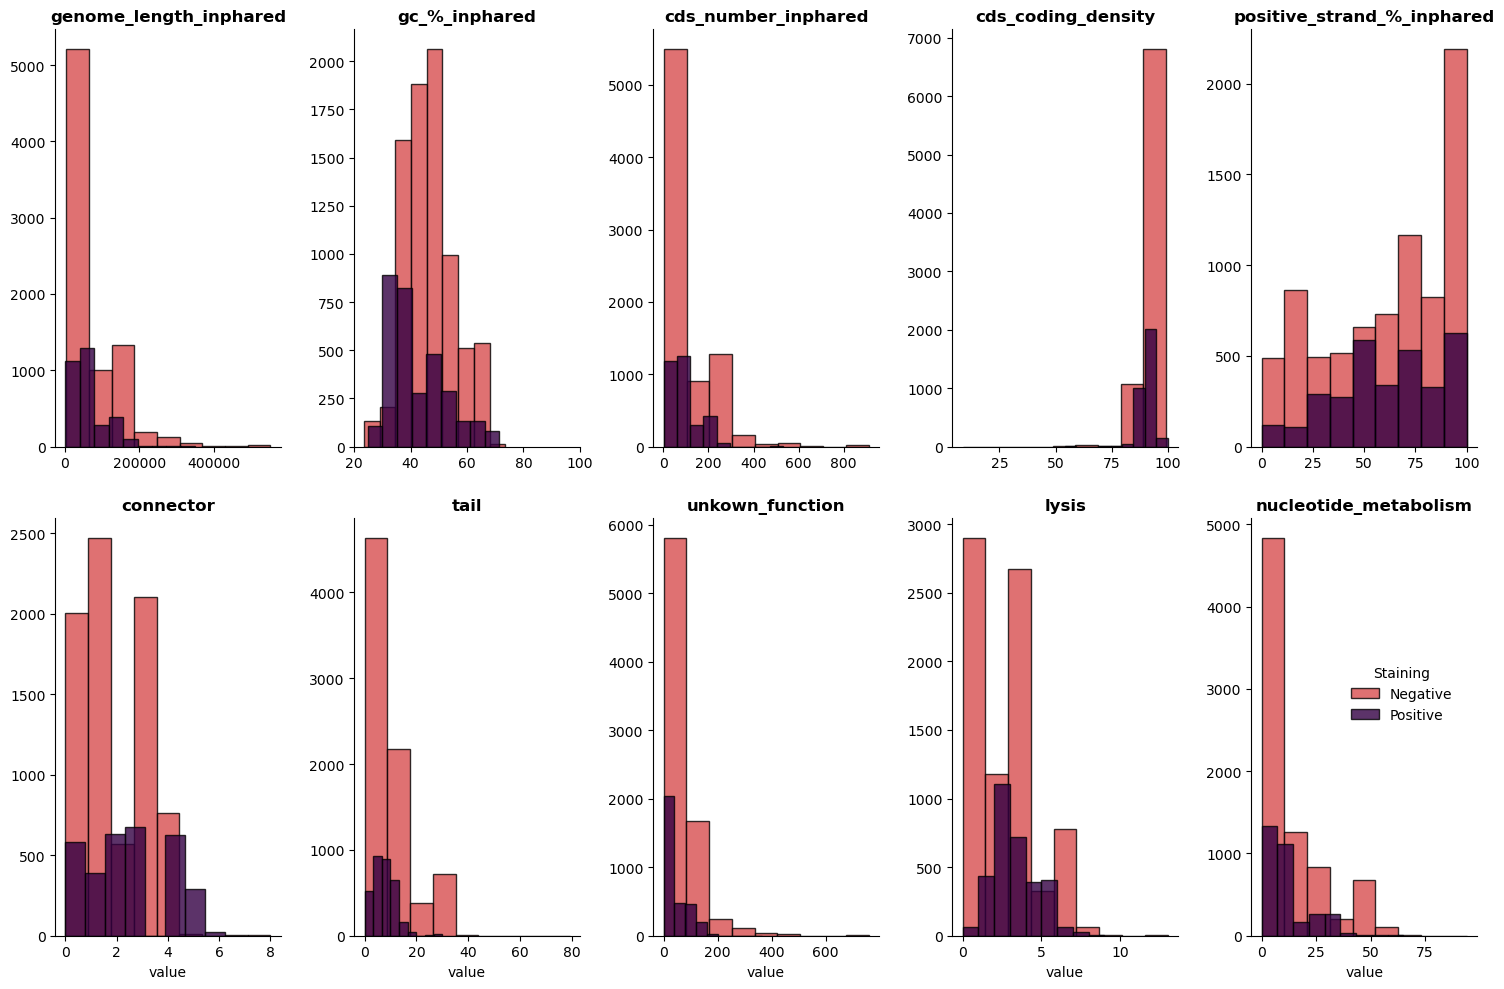

In [10]:
# Define the color palette for the 'staining' groups
palette = {0: '#D74D4F', 1: '#330043'}  # Red for 0, Green for 1
df_melted = pd.melt(df, id_vars='staining', value_vars=['length', 'gc_perc', 
                                                         'CDS', 'cds_coding_density', 
                                                         'positive_strand_%', 'connector',
                                                         'tail', 'unkown_function', 'lysis', 
                                                         'nucleotide_metabolism'],
                    var_name='variable', value_name='value')



# Define the plotting function with an alpha value and individual bin calculation
def custom_hist(x, color, label, **kwargs):
    bins = np.linspace(min(x), max(x), 10)  # Calculate bins based on the data in 'x'
    plt.hist(x, bins=bins, color=color, label=label, alpha=0.8, **kwargs)

# Set up the FacetGrid with 3 columns per row, no shared x/y axes, and space between subplots
g = sns.FacetGrid(df_melted, col="variable", hue="staining", palette=palette, col_wrap=5, sharex=False, sharey=False)
# Map the histograms to the grid using the custom_hist function
g.map(custom_hist, 'value', ec="k")

# Add a legend with specified placement
g.add_legend(title='Staining', loc='right', bbox_to_anchor=(0.98, 0.3))
# Modify the legend labels
for t, l in zip(g._legend.texts, ["Negative", "Positive"]):
    t.set_text(l)
    
# Set the title for each subplot to the name of the variable and make it bold
for ax, title in zip(g.axes.flatten(), g.col_names):
    ax.set_title(title, fontweight='bold')
    # Modify x-axis ticks for 'gc_%_inphared'
    if title == 'gc_%_inphared':
        ax.set_xticks([20, 40, 60, 80, 100])

# Adjust the layout
# Increase the height parameter to introduce more separation between rows
g.fig.set_size_inches(15, 10)  # Example size, adjust as needed
g.fig.tight_layout( h_pad=2)  # Adjust h_pad for vertical spacing
output_directory = "output/"
name = os.path.join(output_directory, '1_barplot_combined.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  


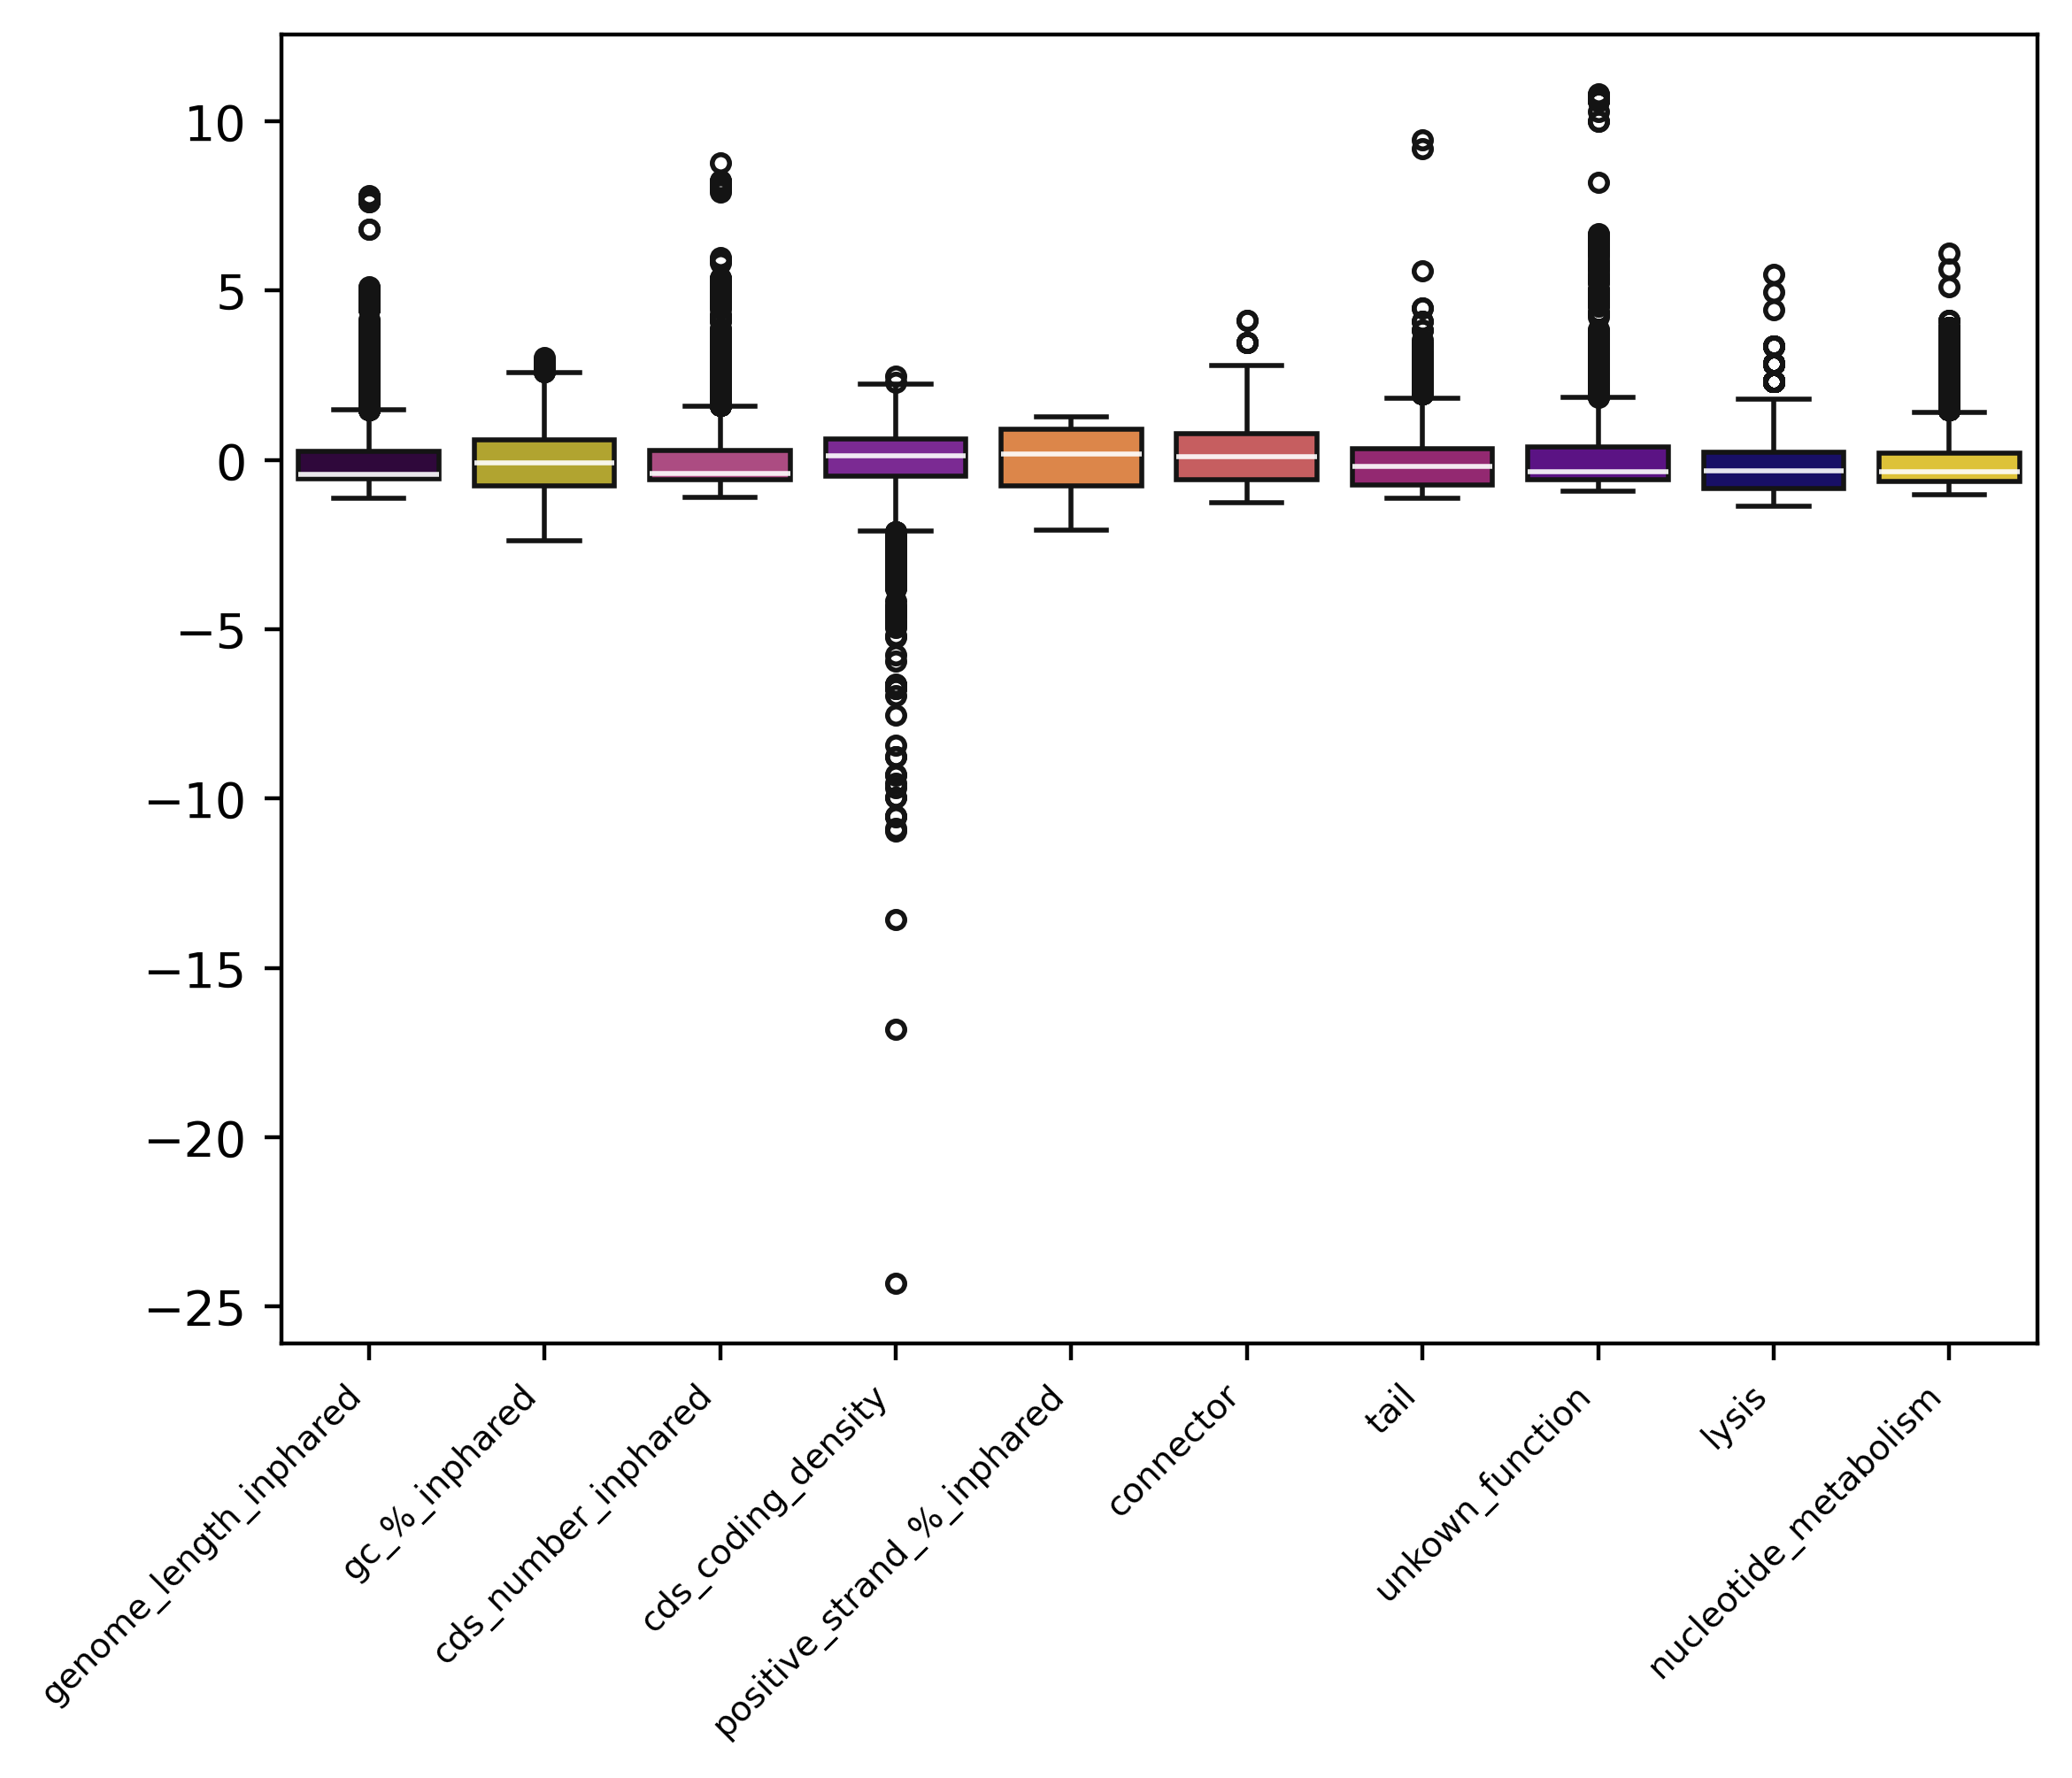

In [11]:
# Boxplot
mean=df.mean(axis=0)
std=df.std(axis=0)
# 2.2 Histogram
C1 = '#330043'
C2 = '#C7B51A'
C3 = '#BC3C84'
C4 = '#8519A4'
C5 = '#F48132'
C6 = '#D74D4F'
C7 = '#A51778'
C8 = '#600097'
C9 = '#0C0074'
C10 = '#F8D41D'
# then we subtract the mean
df_mean=df-mean
# and divide with the standard deviation
df_std=df_mean/std

# then we create the boxplot
plt.figure(dpi=400)


ax = sns.boxplot(data=df_std[['length', 'gc_perc', 'CDS', 'cds_coding_density', 'positive_strand_%', 'connector',
'tail', 'unkown_function', 'lysis', 'nucleotide_metabolism']], 
          palette=[C1, C2, C3, C4, C5, C6, C7, C8, C9, C10], 
          showfliers=True, orient="v", medianprops=dict(color="white", alpha=0.9), 
          fliersize = 3.5)

# Reduce the text size of x-axis ticks
plt.xticks(rotation=45, ha='right', fontsize=7.0)  # Adjust fontsize as needed

name = os.path.join(output_directory, '1_boxplot.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  
plt.show()



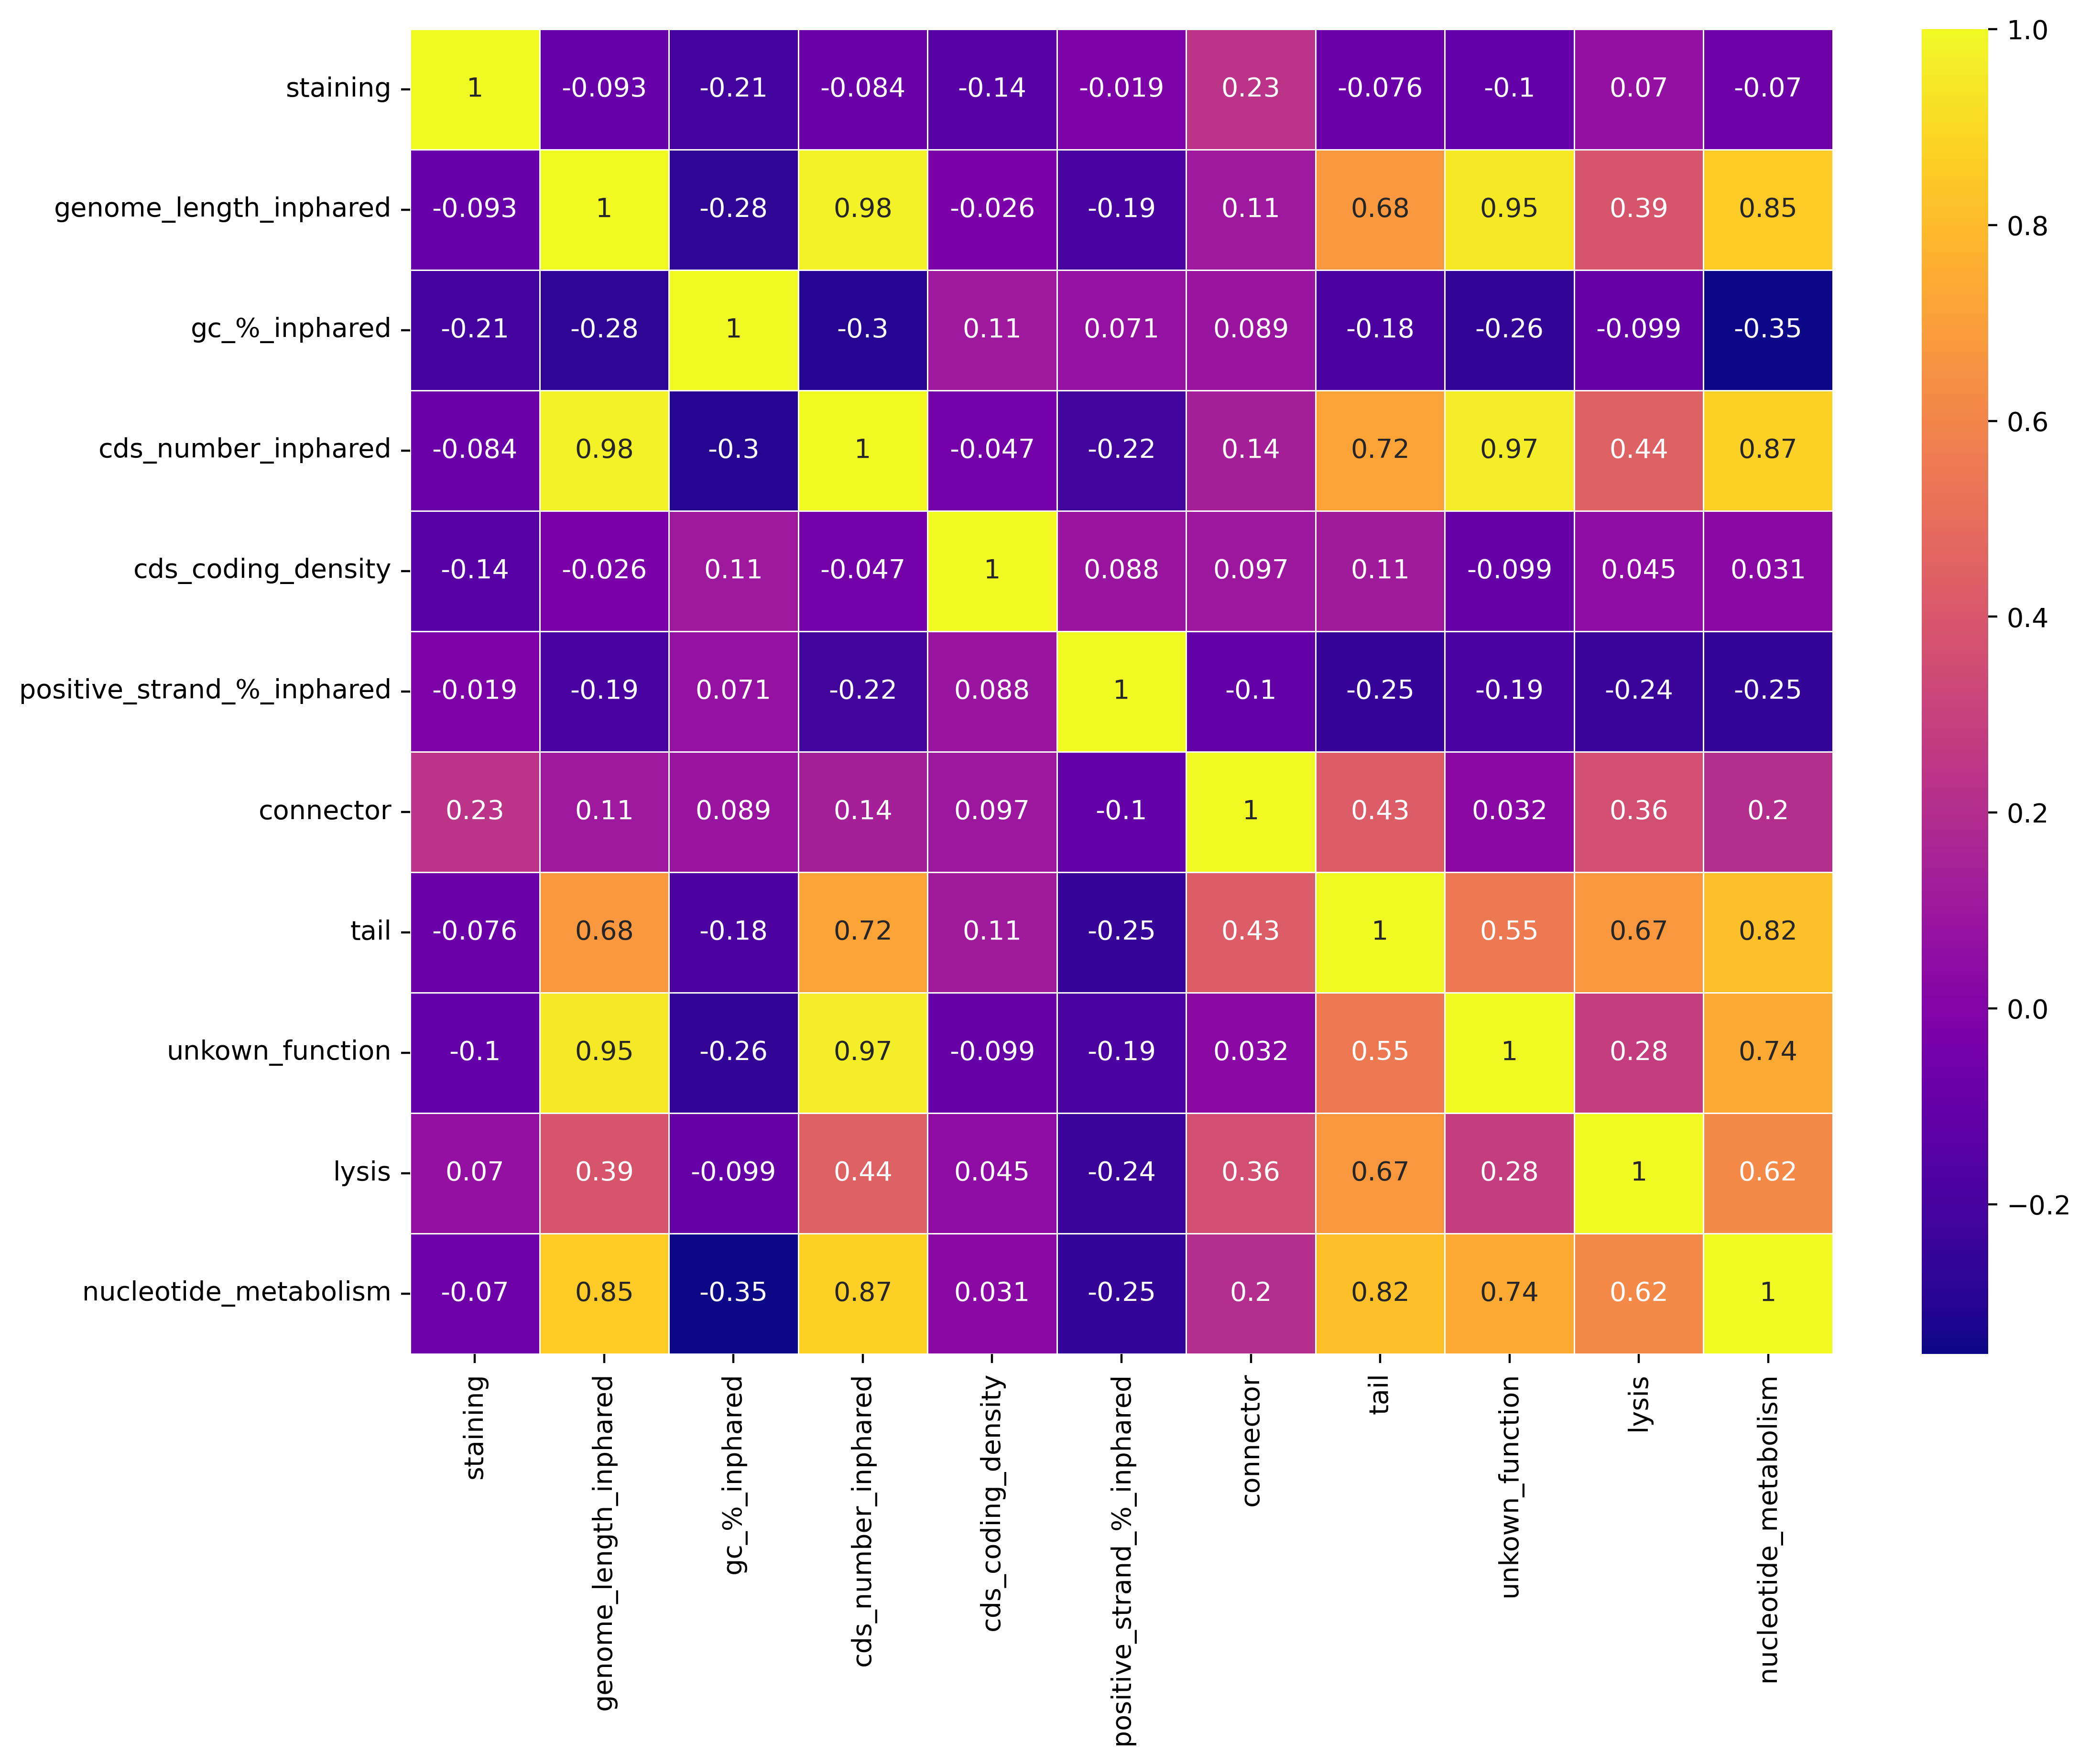

In [12]:
# Heatmap
plt.figure(figsize=(12, 9), dpi=400)


changed_df = df
#creating corr variable to store the changed df
corr = changed_df[['length', 'gc_perc', 'CDS', 'cds_coding_density', 'positive_strand_%', 
                   'connector','tail', 'unkown_function', 'lysis', 'nucleotide_metabolism',
                   'staining']].corr()
corr = df.corr()

sns.heatmap(corr, annot=True, cmap='plasma', linewidths=0.5)
name = os.path.join(output_directory, '1_heatmap.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  

## 4.2 Training

- Input: df with engineered features (one is stainig)
- Output: trained model pickle file plus training metrics in plots

In [13]:
# Data for training
print("-> Starting Training of Model ----------------------")

df = pd.read_csv("data/features_with_gram_class.csv")

# Creating new manual features again because there was a bug 
df['positive_strand_%'] = round(df['frame_positive'] / df['CDS'] * 100,2)
df['negative_strand_%'] = round(df['frame_negative'] / df['CDS'] * 100,2)


# df = df[['id','host_inphared','isolation_host_inphared','length', 'jumbophage', 'gc_perc',
#         'CDS','frame_positive', 'frame_negative', 'cds_coding_density',  'positive_strand_%',
#         "negative_strand_%",'CARD_AMR_Genes', 'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
#        'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
#        'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
#        'transcription', 'unkown_function', 'transl_table', 'sequence']]


df['staining'] = df['staining'].replace({'negative': 0, 'positive': 1})
df.shape

-> Starting Training of Model ----------------------


(11143, 35)

## 4.3 Mash and NetworkX

**IMPORTANT**

To run Mash, I produce some temporary files on the current directory. The directory should be automatically deleted after the distances have been retrieved and the process takes around 5 min. I suggest that if you want to try it out, good, but otherwise comment it out

In [14]:
# MASH
# Obtaining sequences
genomes = {}

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    genomes[row['id']] = row['sequence']

def unix_call(command):
    result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return result.stdout.decode('utf-8')  # Decode stdout to string

def mash_dist_pair(file_1, file_2):
    command = f"mash dist {file_1} {file_2}"
    try:
        dist_output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        result = dist_output.decode('utf-8').strip()

        # Parse the output to extract shared hashes and total hashes
        parts = result.split('\t')  # Split the mash output into parts
        shared_hashes_info = parts[4]  # Get the shared hashes information
        shared, total = map(int, shared_hashes_info.split('/'))  # Split into shared and total hashes
        identity = (shared / total) * 100 if total > 0 else 0  # Calculate identity percentage

        # Return the result with identity percentage added
        return (os.path.splitext(os.path.basename(file_1))[0],  # Genome1 ID
                os.path.splitext(os.path.basename(file_2))[0],  # Genome2 ID
                parts[2],  # Distance
                parts[3],  # P-value
                shared_hashes_info,  # Shared-hashes
                identity)  # Identity percentage

    except subprocess.CalledProcessError as e:
        error_message = f"Error: {e.output.decode()}"
        # Provide a formatted error tuple consistent with the successful output
        return (os.path.splitext(os.path.basename(file_1))[0],
                os.path.splitext(os.path.basename(file_2))[0],
                parts[2],  # Distance
                parts[3],  # P-value
                shared_hashes_info,  # Shared-hashes
                identity)  # Identity percentage
    
def cluster_genomes(genomes, create_sketch=True, batch_size = 500):
    temp_dir = "./temp_mash"
    sketch_files = []
    
    # Check if temp_dir already exists and has files
    if os.path.exists(temp_dir) and os.path.isdir(temp_dir):
        # Check if the directory has sketch files or fasta files depending on create_sketch flag
        existing_files = os.listdir(temp_dir)
        for genome_id in genomes.keys():
            expected_file = f"{genome_id}.msh" if create_sketch else f"{genome_id}.fna"
            if expected_file in existing_files:
                sketch_files.append(os.path.join(temp_dir, expected_file))
            else:
                # If expected files are not found, they need to be created
                print(f"Expected file {expected_file} not found in {temp_dir}.")
                # Set flag to indicate file creation is required
                create_files = True
                break
        else:
            # Set flag to indicate no file creation is required if all files were found
            create_files = False
    else:
        # If the directory doesn't exist, create it and set flag to create files
        os.makedirs(temp_dir, exist_ok=True)
        create_files = True

    if create_files:
        print("Producing temporary files for MASH...")
        # print("FASTA files are being created")

        # Create FASTA or sketch files if needed
        for genome_id, sequence in genomes.items():
            file_path = os.path.join(temp_dir, f"{genome_id}.fna")
            with open(file_path, 'w') as file:
                file.write(f">{genome_id}\n{sequence}\n")
            
            if create_sketch:
                sketch_prefix = file_path.replace('.fna', '')  # Remove the '.fna' for mash output prefix
                # print(f"Sketch files are being created for {sketch_prefix} {file_path}")
                unix_call(f"mash sketch -o {sketch_prefix} {file_path}")
                sketch_files.append(sketch_prefix + '.msh')  # Append the .msh path
            else:
                sketch_files.append(file_path)  # Append the .fna path

    pairs = [(sketch_files[i], sketch_file) for i in range(len(sketch_files)) for sketch_file in sketch_files[i + 1:]]
    

    with ProcessPoolExecutor() as executor, open('output/mash_distances.csv', 'w') as output_file:
        output_file.write('Genome1,Genome2,Distance,P-value,Shared-hashes,Identity\n')  # Update the header with the new column
        for batch_start in range(0, len(sketch_files), batch_size):
            batch_end = min(batch_start + batch_size, len(sketch_files))
            batch_pairs = [(sketch_files[i], sketch_file) for i in range(batch_start, batch_end) for sketch_file in sketch_files[i+1:batch_end]]
            
            futures = {executor.submit(mash_dist_pair, pair[0], pair[1]): pair for pair in batch_pairs}
            for future in as_completed(futures):
                file_1, file_2, distance, p_value, shared_hashes, identity = future.result()  # Update to receive identity
                if not distance.startswith("Error"):  # Only write if no error occurred
                    # Write including the new identity percentage
                    output_file.write(f"{file_1},{file_2},{distance},{p_value},{shared_hashes},{identity:.2f}\n")
            # Print the completion message for the batch
            print(f"Completed processing batch from {batch_start} to {batch_end - 1}")

    shutil.rmtree(temp_dir)  # Clean up temporary directory
    print("**MASH clustering completed**")
    return pd.read_csv('output/mash_distances.csv')


args_distance= 'output/mash_distances.csv'
args_distance = None
if args_distance is None:
    distances = cluster_genomes(genomes, create_sketch=True, batch_size = 10)
    
else:
    distances = pd.read_csv(args_distance)
    print("Already existing distances have been processed.")

Producing temporary files for MASH...
Completed processing batch from 0 to 9
Completed processing batch from 10 to 19
Completed processing batch from 20 to 29
Completed processing batch from 30 to 39
Completed processing batch from 40 to 49
Completed processing batch from 50 to 59
Completed processing batch from 60 to 69
Completed processing batch from 70 to 79
Completed processing batch from 80 to 89
Completed processing batch from 90 to 99
Completed processing batch from 100 to 109
Completed processing batch from 110 to 119
Completed processing batch from 120 to 129
Completed processing batch from 130 to 139
Completed processing batch from 140 to 149
Completed processing batch from 150 to 159
Completed processing batch from 160 to 169
Completed processing batch from 170 to 179
Completed processing batch from 180 to 189
Completed processing batch from 190 to 199
Completed processing batch from 200 to 209
Completed processing batch from 210 to 219
Completed processing batch from 220 to

In [15]:
# NetworkX
distances = pd.read_csv('data/mash_distances.csv')
from networkx.algorithms import community

# Create a new graph
G = nx.Graph()

# Add edges to the graph based on our distances
for index, row in distances.iterrows():
    distance = 1 - row['Identity'] / 100  # Convert percentage to a float value between 0 and 1
    G.add_edge(row['Genome1'], row['Genome2'], weight=distance)

# Verify that the graph is not empty
if G.number_of_edges() == 0:
    raise ValueError("The graph G has no edges. Check the 'mash_distances.csv' file for correct data.")

# If there are edges, print the number of edges and nodes
print(f"The graph G has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Proceed to detect communities only if the graph is not empty
if G.number_of_nodes() > 0:
    communities = community.greedy_modularity_communities(G, weight='weight')
else:
    print("Cannot find communities in an empty graph.")

# Create a mapping dictionary from accession code to community index
accession_to_community = {}
for i, community in enumerate(communities):
    for accession in community:
        accession_to_community[accession] = i


The graph G has 11143 nodes and 50133 edges.


In [16]:
# Map the 'Accession' column to a new 'Community' column
df['Community'] = df['id'].map(accession_to_community)

df= df.set_index('id')

## 4.4 Setting up the splits

In [17]:
X = df.drop(['staining', 'Community', 'sequence'], axis=1)
y = df['staining']

# The groups will be used to decide the splits further on
groups = df['Community'].to_list()
groups = np.array(groups)

print(groups)

[   0    0    0 ... 1114 1114 1114]


In [18]:
features =['length', 'jumbophage', 'gc_perc', 'CDS', 'frame_positive',
       'frame_negative', 'cds_coding_density', 'positive_strand_%',
       'negative_strand_%', 'CARD_AMR_Genes', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'transl_table']



target = 'staining'


## 4.5 Models

### 4.5.1 Random

In [19]:
folds = 10
group_kfold = GroupKFold(n_splits=10)

# Variables to track the best model and its performance
best_mcc = -1  # Initialize with a low MCC
best_model = None

# Lists to store metrics
accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs_random = []  # True Positive Rates
fprs_random = []  # False Positive Rates
precisions_random = []
recalls_random = []
roc_auc_values = []
pr_auc_values = []
tp_values = []
fp_values = []
tn_values = []
fn_values = []

for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Training fold {i + 1}...")
    X_train_fold, X_validation_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_validation_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_validation_scaled = scaler.transform(X_validation_fold)
    
    # Train the random classifier
    random_model = DummyClassifier(strategy='uniform')
    random_model.fit(X_train_scaled, y_train_fold)

    # Predict class labels and probabilities
    y_pred = random_model.predict(X_validation_scaled)
    y_pred_proba = random_model.predict_proba(X_validation_scaled)[:, 1]
    print("Printing y_pred_proba" , str(y_pred_proba))
    # Encode labels
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)
    logloss = log_loss(y_validation_encoded, y_pred_proba)
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)
    f1score = f1_score(y_validation_encoded, y_pred_encoded)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)


    if mcc > best_mcc:
        best_mcc = mcc
        best_model = random_model

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs_random.append(tpr)
    fprs_random.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    print("Precision",str(precision))
    print("Recall", str(recall))
    precisions_random.append(precision)

    recalls_random.append(recall)

    pr_auc = auc(recall, precision)
    print(f'Calculated PR AUC: {pr_auc:.2f}')
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_validation_encoded, y_pred_encoded).ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_random = pd.DataFrame({
    'Fold': range(1, folds+1),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': fn_values
})

output = "output/models/"
# After the loop, save the best model
if best_model is not None:
    model_filename = os.path.join(output, 'random.pkl')

    with open(model_filename, 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Best model saved with MCC: {best_mcc}")
else:
    print("No model was saved.")

metrics_random

Training fold 1...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.26607143 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.63
Training fold 2...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.26517857 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.63
Training fold 3...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.27946429 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.64
Training fold 4...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.28125 1.     ]
Recall [1. 0.]
Calculated PR AUC: 0.64
Training fold 5...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.28930818 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.64
Training fold 6...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.27837838 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.64
Training fold 7...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.3009009 1.       ]
Recall [1. 0.]
Calculated PR AUC: 0.65


,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC,ROC AUC,PR AUC,True Positives,False Positives,True Negatives,False Negatives
0,1,0.465179,0.461303,0.693147,0.534821,0.310702,-0.068414,0.5,0.633036,135,436,386,163
1,2,0.466964,0.467300,0.693147,0.533036,0.317714,-0.057769,0.5,0.632589,139,439,384,158
2,3,0.501786,0.501728,0.693147,0.498214,0.360092,0.003102,0.5,0.639732,157,402,405,156
3,4,0.514286,0.521049,0.693147,0.485714,0.383220,0.037858,0.5,0.640625,169,398,407,146
4,5,0.494160,0.495891,0.693147,0.505840,0.363842,-0.007453,0.5,0.644654,161,402,389,161
5,6,0.481982,0.486025,0.693147,0.518018,0.347333,-0.025067,0.5,0.639189,153,419,382,156
6,7,0.493694,0.486963,0.693147,0.506306,0.358447,-0.023924,0.5,0.650450,157,385,391,177
7,8,0.498198,0.491662,0.693147,0.501802,0.372041,-0.015479,0.5,0.656757,165,374,388,183
8,9,0.514414,0.515463,0.693147,0.485586,0.389581,0.028320,0.5,0.649550,172,379,399,160
9,10,0.507207,0.497443,0.693147,0.492793,0.374857,-0.004751,0.5,0.656757,164,363,399,184


### 4.5.2 Logistic Regressor

In [20]:
feature_importances = np.zeros(len(features))
accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs_lr = []  # True Positive Rates
fprs_lr = []  # False Positive Rates
precisions_lr = []
recalls_lr = []
roc_auc_values = []
pr_auc_values = []
tp_values = []  # True Positives
fp_values = []  # False Positives
tn_values = []  # True Negatives
fn_values = []  # False Negatives
best_mcc = -1  # Initialize with a low MCC
best_model = None


for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Training fold {i + 1}...")
    X_train_fold, X_validation_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_validation_fold = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups[train_index]
    
    # Standardize the features (fit on training data, transform on both training and test data)
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_validation_fold = scaler.transform(X_validation_fold)  # Use the same scaler to transform the test data
    
    params = {'C': 0.1, 'class_weight': None, 'max_iter': 10000, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'saga'}
    # Train a RandomForestClassifier model
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train_fold, y_train_fold)


    # Predict probabilities on the validation set
    y_pred_proba = model.predict_proba(X_validation_fold)[:, 1]  # Probabilities for the positive class

    # Predict class labels for F1 score calculation
    y_pred = model.predict(X_validation_fold)

    # Encode labels for mean squared error calculation
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate F1 score
    positive_label = '1'
    f1score = f1_score(y_validation_encoded, y_pred_encoded, pos_label=label_encoder.transform([positive_label])[0])

    # Calculate log loss using predicted probabilities
    logloss = log_loss(y_validation_encoded, y_pred_proba)

    # Calculate mean squared error using encoded labels
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)

    if mcc > best_mcc:
        best_mcc = mcc
        best_model = model

    # Generate the classification report
    classification_report_str = classification_report(y_validation_encoded, y_pred_encoded)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs_lr.append(tpr)
    fprs_lr.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    precisions_lr.append(precision)
    recalls_lr.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_validation_encoded, y_pred_encoded)
    tn, fp, fn, tp = cm.ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_lr = pd.DataFrame({
    'Fold': range(1, folds+1),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': fn_values})


# output = "../models/"
# # After the loop, save the best model
# if best_model is not None:
#     model_filename = os.path.join(output, 'logistic.pkl')

#     with open(model_filename, 'wb') as file:
#         pickle.dump(best_model, file)
#     print(f"Best model saved with MCC: {best_mcc}")
# else:
#     print("No model was saved.")


metrics_lr


Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Training fold 6...
Training fold 7...
Training fold 8...
Training fold 9...
Training fold 10...
Best model saved with MCC: 0.5556708582917698


,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC,ROC AUC,PR AUC,True Positives,False Positives,True Negatives,False Negatives
0,1,0.778571,0.670529,0.469957,0.221429,0.513725,0.384734,0.787472,0.618621,131,81,741,167
1,2,0.813393,0.718086,0.405944,0.186607,0.594175,0.486300,0.854977,0.718409,153,65,758,144
2,3,0.770536,0.667686,0.481507,0.229464,0.514178,0.381439,0.792669,0.630058,136,80,727,177
3,4,0.790179,0.685921,0.455139,0.209821,0.545455,0.434826,0.812860,0.664353,141,61,744,174
4,5,0.776280,0.666754,0.489670,0.223720,0.512720,0.402768,0.783889,0.623763,131,58,733,191
5,6,0.801802,0.704641,0.447421,0.198198,0.576923,0.467517,0.828463,0.670580,150,61,740,159
6,7,0.809910,0.731882,0.435231,0.190090,0.629174,0.520670,0.845731,0.739172,179,56,720,155
7,8,0.818018,0.737092,0.441738,0.181982,0.641844,0.555671,0.854670,0.749784,181,35,727,167
8,9,0.771171,0.674451,0.498248,0.228829,0.531365,0.407879,0.798731,0.623571,144,66,712,188
9,10,0.777477,0.706003,0.490378,0.222523,0.591736,0.453137,0.815952,0.662885,179,78,684,169


### 4.5.3 Random Forest

In [21]:
feature_importances = np.zeros(len(features))
accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs_rf = []  # True Positive Rates
fprs_rf = []  # False Positive Rates
precisions_rf = []
recalls_rf = []
roc_auc_values = []
pr_auc_values = []
tp_values = []  # True Positives
fp_values = []  # False Positives
tn_values = []  # True Negatives
fn_values = []  # False Negatives
best_mcc = -1  # Initialize with a low MCC
best_model = None
best_scaler = StandardScaler()


for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Training fold {i + 1}...")
    X_train_fold, X_validation_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_validation_fold = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups[train_index]
    
    # Standardize the features (fit on training data, transform on both training and test data)
    scaler  = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_validation_fold = scaler.transform(X_validation_fold)  # Use the same scaler to transform the test data
    
    params =  {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
    # Train a RandomForestClassifier model
    model = RandomForestClassifier(**params)
    # model.feature_names_in_ = features

    model.fit(X_train_fold, y_train_fold)
    
    # Sum the feature importances from this fold
    feature_importances += model.feature_importances_

    # Predict probabilities on the validation set
    y_pred_proba = model.predict_proba(X_validation_fold)[:, 1]  # Probabilities for the positive class

    # Predict class labels for F1 score calculation
    y_pred = model.predict(X_validation_fold)

    # Encode labels for mean squared error calculation
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate F1 score
    positive_label = '1'
    f1score = f1_score(y_validation_encoded, y_pred_encoded, pos_label=label_encoder.transform([positive_label])[0])

    # Calculate log loss using predicted probabilities
    logloss = log_loss(y_validation_encoded, y_pred_proba)

    # Calculate mean squared error using encoded labels
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)

    if mcc > best_mcc:
        best_mcc = mcc
        best_model = model
        best_scaler = scaler

    # Generate the classification report
    classification_report_str = classification_report(y_validation_encoded, y_pred_encoded)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs_rf.append(tpr)
    fprs_rf.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    precisions_rf.append(precision)
    recalls_rf.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_validation_encoded, y_pred_encoded)
    tn, fp, fn, tp = cm.ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_rf = pd.DataFrame({
    'Fold': range(1, folds+1),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': fn_values})


# output = "../models/"
# # After the loop, save the best model
# if best_model is not None:
#     model_filename = os.path.join(output, 'random_forest.pkl')

#     with open(model_filename, 'wb') as file:
#         pickle.dump(best_model, file)
#     print(f"Best model saved with MCC: {best_mcc}")
# else:
#     print("No model was saved.")


# # Save the best scaler using pickle
# scaler_filename = os.path.join(output, 'scaler.pkl')
# with open(scaler_filename, 'wb') as scaler_file:
#     pickle.dump(best_scaler, scaler_file)

metrics_rf


Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Training fold 6...
Training fold 7...
Training fold 8...
Training fold 9...
Training fold 10...
Best model saved with MCC: 0.9539728762323052


,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC,ROC AUC,PR AUC,True Positives,False Positives,True Negatives,False Negatives
0,1,0.974107,0.956690,0.080080,0.025893,0.949740,0.933245,0.996195,0.991491,274,5,817,24
1,2,0.982143,0.973862,0.091673,0.017857,0.965986,0.953973,0.997382,0.992468,284,7,816,13
2,3,0.965179,0.946500,0.123687,0.034821,0.935537,0.912755,0.991457,0.984299,283,9,798,30
3,4,0.968750,0.950242,0.147087,0.031250,0.942339,0.922194,0.990204,0.985799,286,6,799,29
4,5,0.971249,0.956755,0.148736,0.028751,0.948882,0.929648,0.988960,0.984194,297,7,784,25
5,6,0.978378,0.966135,0.072742,0.021622,0.960265,0.945904,0.997331,0.993659,290,5,796,19
6,7,0.977477,0.965986,0.060836,0.022523,0.961598,0.946325,0.998314,0.996399,313,4,772,21
7,8,0.973874,0.966139,0.115924,0.026126,0.957787,0.939044,0.993039,0.988684,329,10,752,19
8,9,0.967568,0.951827,0.086444,0.032432,0.943925,0.922221,0.995608,0.991196,303,7,771,29
9,10,0.971171,0.964171,0.085498,0.028829,0.953623,0.932785,0.994321,0.990108,329,13,749,19


### 4.5.4 LightGBM

In [22]:
import lightgbm as lgb

In [23]:
feature_importances = np.zeros(len(features))
accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs_rf = []  # True Positive Rates
fprs_rf = []  # False Positive Rates
precisions_rf = []
recalls_rf = []
roc_auc_values = []
pr_auc_values = []
tp_values = []  # True Positives
fp_values = []  # False Positives
tn_values = []  # True Negatives
fn_values = []  # False Negatives
best_mcc = -1  # Initialize with a low MCC
best_model = None
best_scaler = StandardScaler()


for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Training fold {i + 1}...")
    X_train_fold, X_validation_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_validation_fold = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups[train_index]
    
    # Standardize the features (fit on training data, transform on both training and test data)
    scaler  = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_validation_fold = scaler.transform(X_validation_fold)  # Use the same scaler to transform the test data
    
    # Train a LGBM model model
 
    model = lgb.LGBMClassifier()
    model.fit(X_train_fold, y_train_fold, feature_name=features)


    # Sum the feature importances from this fold
    # feature_importances += model.feature_importances_

    # Predict probabilities on the validation set
    y_pred_proba = model.predict_proba(X_validation_fold)[:, 1]  # Probabilities for the positive class

    # Predict class labels for F1 score calculation
    y_pred = model.predict(X_validation_fold)

    # Encode labels for mean squared error calculation
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate F1 score
    positive_label = '1'
    f1score = f1_score(y_validation_encoded, y_pred_encoded, pos_label=label_encoder.transform([positive_label])[0])

    # Calculate log loss using predicted probabilities
    logloss = log_loss(y_validation_encoded, y_pred_proba)

    # Calculate mean squared error using encoded labels
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)

    if mcc > best_mcc:
        best_mcc = mcc
        best_model = model
        best_scaler = scaler

    # Generate the classification report
    classification_report_str = classification_report(y_validation_encoded, y_pred_encoded)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs_rf.append(tpr)
    fprs_rf.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    precisions_rf.append(precision)
    recalls_rf.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_validation_encoded, y_pred_encoded)
    tn, fp, fn, tp = cm.ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_lgbm = pd.DataFrame({
    'Fold': range(1, folds+1),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': fn_values})


# output = "../models/"
# # After the loop, save the best model
# if best_model is not None:
#     model_filename = os.path.join(output, 'random_forest.pkl')

#     with open(model_filename, 'wb') as file:
#         pickle.dump(best_model, file)
#     print(f"Best model saved with MCC: {best_mcc}")
# else:
#     print("No model was saved.")


# # Save the best scaler using pickle
# scaler_filename = os.path.join(output, 'scaler.pkl')
# with open(scaler_filename, 'wb') as scaler_file:
#     pickle.dump(best_scaler, scaler_file)

metrics_lgbm


Training fold 1...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2918, number of negative: 7105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2862
[LightGBM] [Info] Number of data points in the train set: 10023, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291130 -> initscore=-0.889900
[LightGBM] [Info] Start training from score -0.889900


Training fold 2...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2919, number of negative: 7104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 10023, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291230 -> initscore=-0.889417
[LightGBM] [Info] Start training from score -0.889417
Training fold 3...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2903, number of negative: 7120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2861
[LightGBM] [Info] Number of data points in th

,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC,ROC AUC,PR AUC,True Positives,False Positives,True Negatives,False Negatives
0,1,0.958036,0.933976,0.119012,0.041964,0.917976,0.891138,0.990210,0.977019,263,12,810,35
1,2,0.971429,0.957964,0.091827,0.028571,0.945205,0.926138,0.992239,0.983613,276,11,812,21
2,3,0.947321,0.922375,0.148802,0.052679,0.901830,0.867319,0.979865,0.963327,271,17,790,42
3,4,0.967857,0.952519,0.117690,0.032143,0.941368,0.919841,0.988883,0.979154,289,10,795,26
4,5,0.957772,0.938988,0.142191,0.042228,0.924559,0.896266,0.980248,0.968407,288,13,778,34
5,6,0.973874,0.961026,0.114297,0.026126,0.952066,0.934528,0.984906,0.978780,288,8,793,21
6,7,0.964865,0.946733,0.101199,0.035135,0.939158,0.916126,0.992793,0.988046,301,6,770,33
7,8,0.957658,0.944961,0.125526,0.042342,0.930984,0.900921,0.985444,0.979731,317,16,746,31
8,9,0.954955,0.936786,0.126544,0.045045,0.922118,0.891521,0.990457,0.980486,296,14,764,36
9,10,0.954054,0.941556,0.129124,0.045946,0.925329,0.892502,0.986394,0.977159,316,19,743,32


## 4.6 Feature importance

In [24]:
X_train, X_validation, y_train, y_validation = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

Logistic regressor

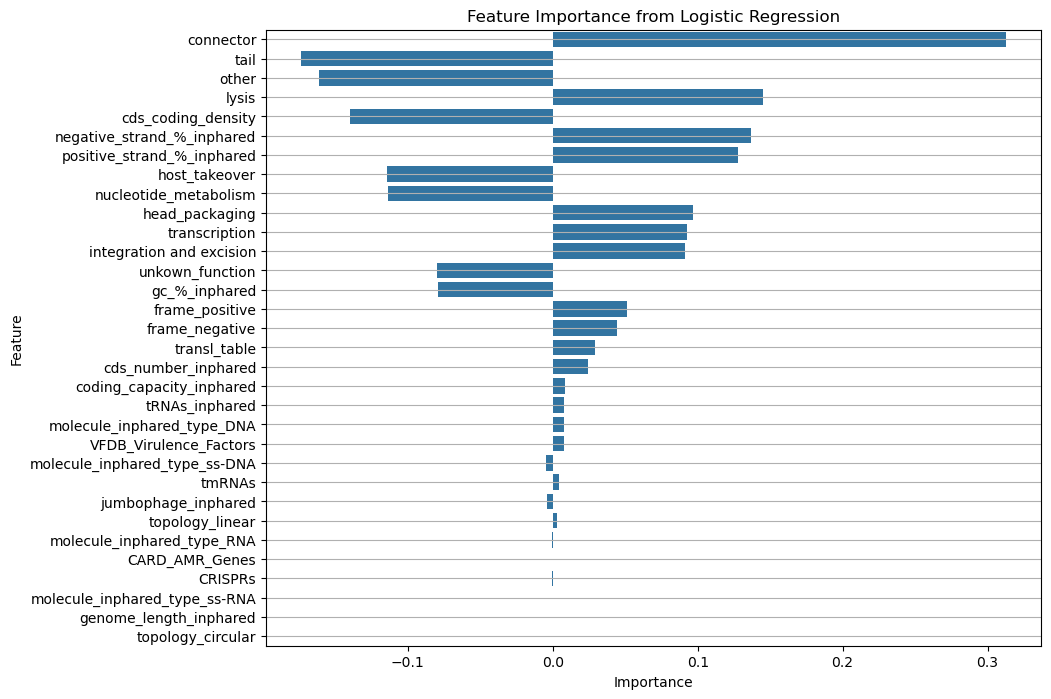

In [25]:
from sklearn.linear_model import LogisticRegression

# Assuming X_train and y_train are your features and target variable
logistic_model = LogisticRegression(max_iter = 10000)
logistic_model.fit(X_train, y_train)

# Get the coefficients
logistic_importance = logistic_model.coef_[0]  # Coefficients for the features

# Match the feature names with the coefficients
feature_names = X.columns
logistic_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': logistic_importance})

# Sort by absolute value of importance
logistic_feature_importance = logistic_feature_importance.reindex(logistic_feature_importance.Importance.abs().sort_values(ascending=False).index)
# Plotting feature importances for Logistic Regression
plt.figure(figsize=(10, 8))
sns.barplot(data=logistic_feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance from Logistic Regression')
# Add horizontal grid lines
plt.grid(axis='y')


Random Forest

Text(0.5, 1.0, 'Feature Importance from Random Forest')

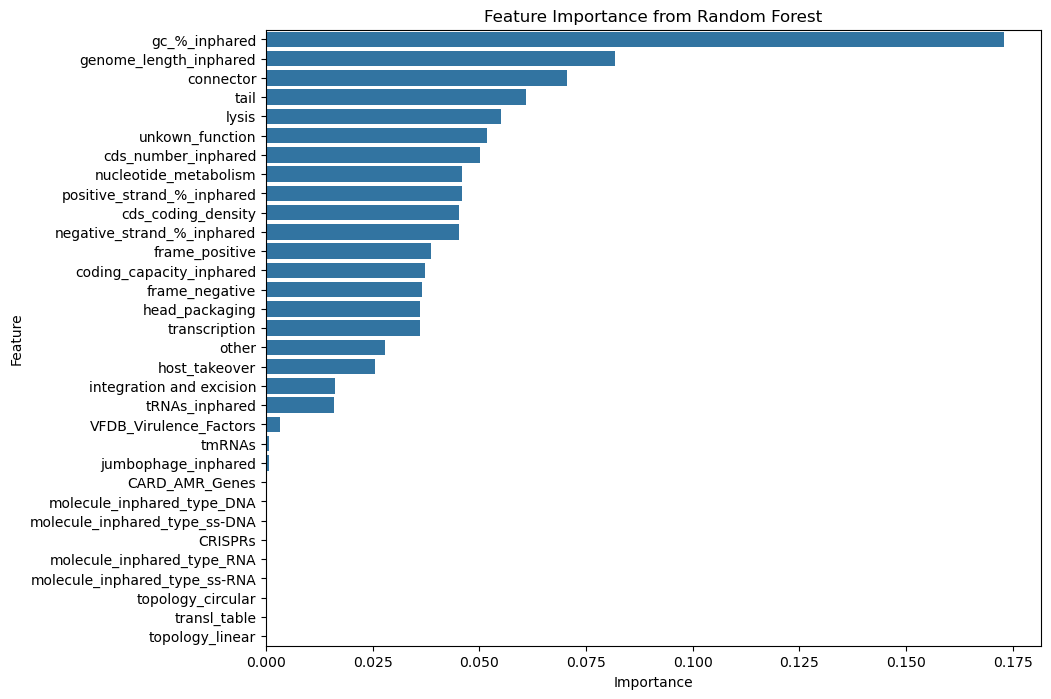

In [26]:
# Assuming X_train and y_train are your features and target variable
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

# Get feature importances
forest_importances = random_forest_model.feature_importances_

# Match the feature names with the importances
feature_names = X.columns
forest_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': forest_importances})

# Sort by the importance scores
forest_feature_importance = forest_feature_importance.reindex(forest_feature_importance.Importance.sort_values(ascending=False).index)


# Plotting feature importances for Random Forest
plt.figure(figsize=(10, 8))
sns.barplot(data=forest_feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance from Random Forest')


LightGBM

In [27]:
# Get feature importances
importance_split = model.booster_.feature_importance(importance_type='split')
importance_gain = model.booster_.feature_importance(importance_type='gain')

# Convert to DataFrame for easy visualization
feature_names = model.feature_name_
df_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Split)': importance_split,
    'Importance (Gain)': importance_gain
}).sort_values(by='Importance (Gain)', ascending=False)

print(df_feature_importances)

                          Feature  Importance (Split)  Importance (Gain)
1                   gc_%_inphared                 428       13585.375963
0          genome_length_inphared                 289        6426.744018
15                      connector                 134        5633.053839
22                           tail                 195        5510.478501
20          nucleotide_metabolism                 175        3504.079094
19                          lysis                 129        2772.790267
25                unkown_function                 182        2571.055939
16                 head_packaging                 173        2261.471931
7              cds_coding_density                 151        2013.459313
17                  host_takeover                 103        1616.523332
3      positive_strand_%_inphared                 109        1589.586180
2             cds_number_inphared                 137        1356.389741
21                          other                  

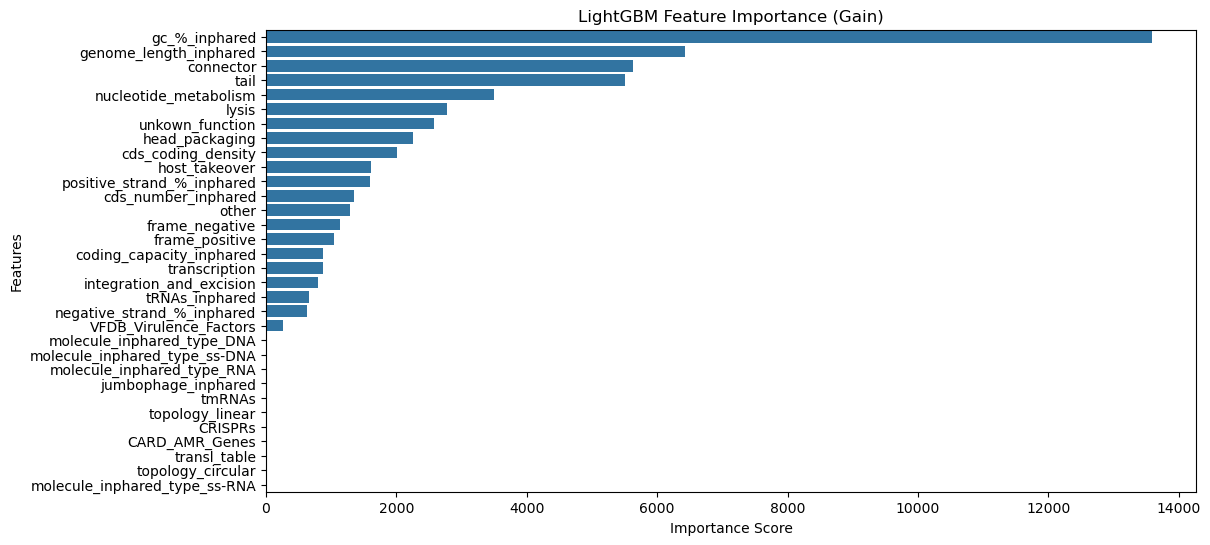

In [28]:
# Plotting
plt.figure(figsize=(12, 6))

sns.barplot(x='Importance (Gain)', y='Feature', data=df_feature_importances)

plt.title('LightGBM Feature Importance (Gain)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 4.7 Learning curves

### 4.7.1 Logistic Regressor

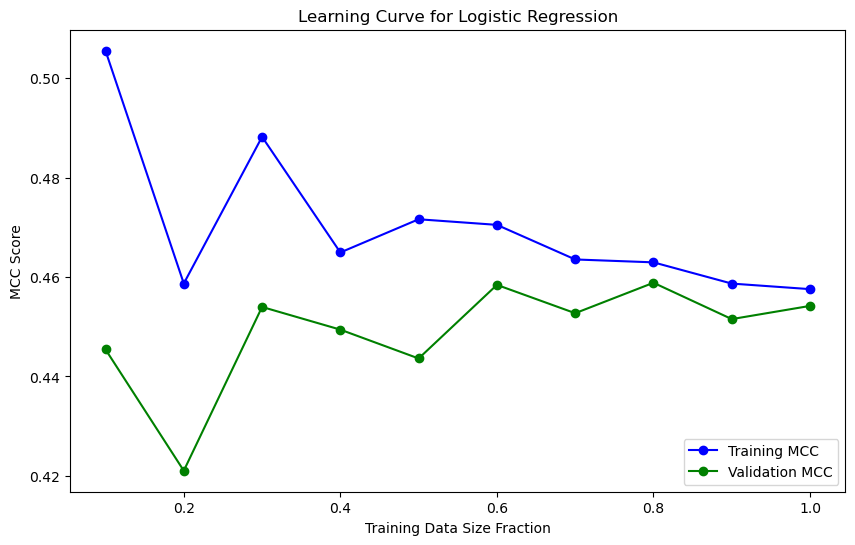

In [29]:
# Define training sizes and GroupKFold
train_sizes = np.linspace(0.1, 1.0, 10)
group_kfold = GroupKFold(n_splits=5)
def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = sum(y_true == 1)
    N = sum(y_true == 0)

    Tp = sum((y_true == 1) & (y_pred == 1))
    Fp = sum((y_true == 0) & (y_pred == 1))

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt((Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return mcc
# Initialize lists to store average training and validation scores
train_mcc_scores = []
validation_mcc_scores = []

# Loop over each training size
for train_size in train_sizes:
    size_train_mcc_scores = []
    size_validation_mcc_scores = []


    # Loop over each fold
    for train_index, test_index in group_kfold.split(X, y, groups):
        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_train = groups[train_index]


        # Get unique groups and sample a subset of them
        unique_groups = np.unique(groups_train)
        # print("Total unique groups:", len(unique_groups))

        n_sampled_groups = int(train_size * len(unique_groups))
        sampled_groups = np.random.choice(unique_groups, n_sampled_groups, replace=False)
        # print("Sampled groups:", sampled_groups)
        # print("Number of sampled groups:", len(sampled_groups))
        # Select data corresponding to sampled groups
        train_subset_mask =  np.isin(groups_train, sampled_groups)
        # print("Mask values:", np.unique(train_subset_mask))
        X_train_subset = X_train[train_subset_mask]
        y_train_subset = y_train[train_subset_mask]


        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_subset)
        X_test_scaled = scaler.transform(X_test)


        # Train a RandomForestClassifier model
        model = LogisticRegression(max_iter=10000)
        model.fit(X_train_scaled, y_train_subset)

        # Compute MCC
        train_mcc = matthews(y_train_subset, model.predict(X_train_scaled))
        validation_mcc = matthews(y_test, model.predict(X_test_scaled))

        size_train_mcc_scores.append(train_mcc)
        size_validation_mcc_scores.append(validation_mcc)

    # Average scores across all folds
    train_mcc_scores.append(np.mean(size_train_mcc_scores))
    validation_mcc_scores.append(np.mean(size_validation_mcc_scores))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mcc_scores, label='Training MCC', color='blue', marker='o')
plt.plot(train_sizes, validation_mcc_scores, label='Validation MCC', color='green', marker='o')
plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training Data Size Fraction')
plt.ylabel('MCC Score')
plt.legend(loc='lower right')

# name = os.path.join(output_directory, '6_learn_logistic.png')
# plt.savefig(name, bbox_inches='tight', dpi=400) 

### 4.7.1 Random Forest

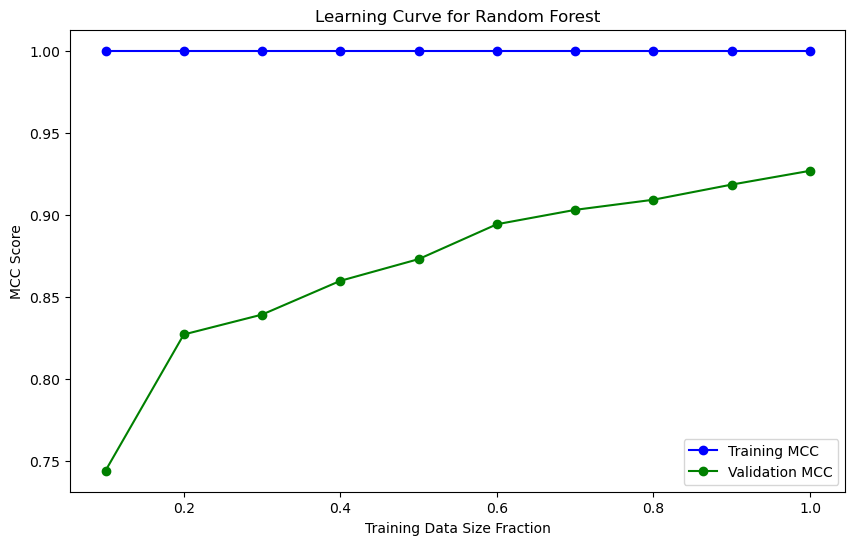

In [30]:
# Define training sizes and GroupKFold
train_sizes = np.linspace(0.1, 1.0, 10)
group_kfold = GroupKFold(n_splits=5)
def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = sum(y_true == 1)
    N = sum(y_true == 0)

    Tp = sum((y_true == 1) & (y_pred == 1))
    Fp = sum((y_true == 0) & (y_pred == 1))

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt((Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return mcc
# Initialize lists to store average training and validation scores
train_mcc_scores = []
validation_mcc_scores = []

# Loop over each training size
for train_size in train_sizes:
    size_train_mcc_scores = []
    size_validation_mcc_scores = []


    # Loop over each fold
    for train_index, test_index in group_kfold.split(X, y, groups):
        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_train = groups[train_index]


        # Get unique groups and sample a subset of them
        unique_groups = np.unique(groups_train)
        # print("Total unique groups:", len(unique_groups))

        n_sampled_groups = int(train_size * len(unique_groups))
        sampled_groups = np.random.choice(unique_groups, n_sampled_groups, replace=False)
        # print("Sampled groups:", sampled_groups)
        # print("Number of sampled groups:", len(sampled_groups))
        # Select data corresponding to sampled groups
        train_subset_mask =  np.isin(groups_train, sampled_groups)
        # print("Mask values:", np.unique(train_subset_mask))
        X_train_subset = X_train[train_subset_mask]
        y_train_subset = y_train[train_subset_mask]


        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_subset)
        X_test_scaled = scaler.transform(X_test)


        params =  {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
        # Train a RandomForestClassifier model
        model = RandomForestClassifier(**params)
        model.fit(X_train_scaled, y_train_subset)

        # Compute MCC
        train_mcc = matthews_corrcoef(y_train_subset, model.predict(X_train_scaled))
        validation_mcc = matthews_corrcoef(y_test, model.predict(X_test_scaled))

        size_train_mcc_scores.append(train_mcc)
        size_validation_mcc_scores.append(validation_mcc)

    # Average scores across all folds
    train_mcc_scores.append(np.mean(size_train_mcc_scores))
    validation_mcc_scores.append(np.mean(size_validation_mcc_scores))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mcc_scores, label='Training MCC', color='blue', marker='o')
plt.plot(train_sizes, validation_mcc_scores, label='Validation MCC', color='green', marker='o')
plt.title('Learning Curve for Random Forest')
plt.xlabel('Training Data Size Fraction')
plt.ylabel('MCC Score')
plt.legend(loc='lower right')

# name = os.path.join(output_directory, '6_learn_random_forest.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  

### 4.7.1 LightGBM

[LightGBM] [Info] Number of positive: 292, number of negative: 598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2276
[LightGBM] [Info] Number of data points in the train set: 890, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328090 -> initscore=-0.716837
[LightGBM] [Info] Start training from score -0.716837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 303, number of negative: 587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2254
[LightGBM] [Info] Number of data points in the train set: 890, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340449 -> initscore=-0.661292
[Li

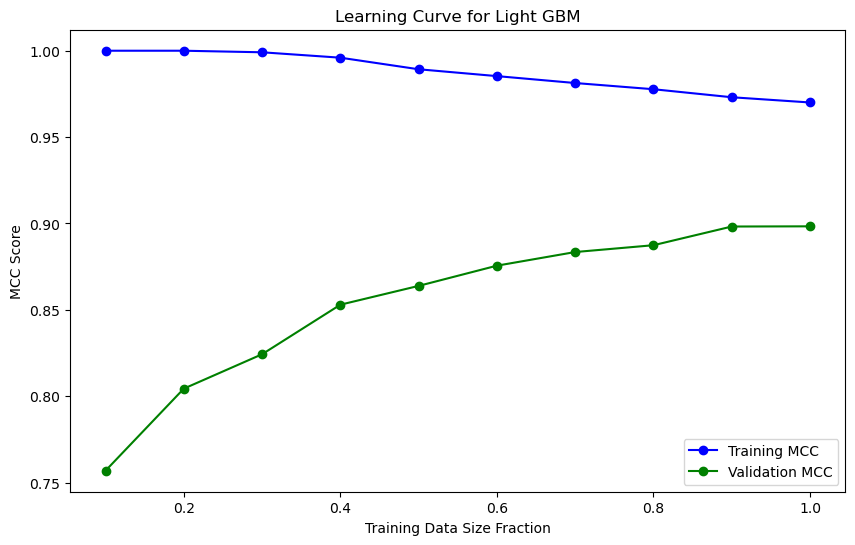

In [31]:
# Define training sizes and GroupKFold
train_sizes = np.linspace(0.1, 1.0, 10)
group_kfold = GroupKFold(n_splits=5)
def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = sum(y_true == 1)
    N = sum(y_true == 0)

    Tp = sum((y_true == 1) & (y_pred == 1))
    Fp = sum((y_true == 0) & (y_pred == 1))

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt((Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return mcc
# Initialize lists to store average training and validation scores
train_mcc_scores = []
validation_mcc_scores = []

# Loop over each training size
for train_size in train_sizes:
    size_train_mcc_scores = []
    size_validation_mcc_scores = []


    # Loop over each fold
    for train_index, test_index in group_kfold.split(X, y, groups):
        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_train = groups[train_index]


        # Get unique groups and sample a subset of them
        unique_groups = np.unique(groups_train)
        # print("Total unique groups:", len(unique_groups))

        n_sampled_groups = int(train_size * len(unique_groups))
        sampled_groups = np.random.choice(unique_groups, n_sampled_groups, replace=False)
        # print("Sampled groups:", sampled_groups)
        # print("Number of sampled groups:", len(sampled_groups))
        # Select data corresponding to sampled groups
        train_subset_mask =  np.isin(groups_train, sampled_groups)
        # print("Mask values:", np.unique(train_subset_mask))
        X_train_subset = X_train[train_subset_mask]
        y_train_subset = y_train[train_subset_mask]


        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_subset)
        X_test_scaled = scaler.transform(X_test)


        params =  {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
        # Train a RandomForestClassifier model
        model = lgb.LGBMClassifier()
        model.fit(X_train_scaled, y_train_subset)

        # Compute MCC
        train_mcc = matthews_corrcoef(y_train_subset, model.predict(X_train_scaled))
        validation_mcc = matthews_corrcoef(y_test, model.predict(X_test_scaled))

        size_train_mcc_scores.append(train_mcc)
        size_validation_mcc_scores.append(validation_mcc)

    # Average scores across all folds
    train_mcc_scores.append(np.mean(size_train_mcc_scores))
    validation_mcc_scores.append(np.mean(size_validation_mcc_scores))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mcc_scores, label='Training MCC', color='blue', marker='o')
plt.plot(train_sizes, validation_mcc_scores, label='Validation MCC', color='green', marker='o')
plt.title('Learning Curve for Light GBM')
plt.xlabel('Training Data Size Fraction')
plt.ylabel('MCC Score')
plt.legend(loc='lower right')

name = os.path.join(output_directory, '6_learn_random_forest.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  

# 5. Predictions on discarded

In [32]:
discarded = pd.read_csv("data/discarded.csv")

features =['host_inphared','isolation_host_inphared','length', 'jumbophage', 'gc_perc', 'CDS', 'frame_positive',
       'frame_negative', 'cds_coding_density', 'positive_strand_%',
       'negative_strand_%', 'CARD_AMR_Genes', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'transl_table']


discarded = discarded.set_index(discarded.columns[0])
discarded = discarded[features]
discarded.head()

,genome_length_inphared,gc_%_inphared,cds_number_inphared,positive_strand_%_inphared,negative_strand_%_inphared,coding_capacity_inphared,tRNAs_inphared,cds_coding_density,jumbophage_inphared,topology_linear,...,tail,tmRNAs,transcription,unkown_function,frame_positive,frame_negative,molecule_inphared_type_DNA,molecule_inphared_type_ss-DNA,molecule_inphared_type_RNA,molecule_inphared_type_ss-RNA
id,,,,,,,,,,,,,,,,,,,,,
GU339467,53332.0,64.530,90.0,40.000000,60.000000,90.416635,1.0,90.11,0.0,True,...,13.0,0.0,3.0,44.0,36.0,54.0,True,False,False,False
MF417929,32618.0,39.218,42.0,16.666667,83.333333,89.416886,0.0,89.29,0.0,True,...,10.0,0.0,1.0,17.0,7.0,35.0,True,False,False,False
MH616963,94878.0,28.507,89.0,56.179775,43.820225,94.964059,2.0,94.70,0.0,True,...,1.0,0.0,0.0,74.0,50.0,39.0,True,False,False,False
MH552500,90023.0,29.180,86.0,47.674419,52.325581,92.927363,2.0,92.83,0.0,True,...,0.0,0.0,0.0,72.0,41.0,46.0,True,False,False,False
BK010471,97065.0,29.274,91.0,50.549451,49.450549,94.458353,0.0,94.52,0.0,True,...,2.0,0.0,0.0,74.0,47.0,45.0,True,False,False,False


In [33]:
args_model = "data/random_forest.pkl"
args_output = 'output/'
# Making the prediction -----

# Load the model using the provided path
model = pickle.load(open(args_model, "rb"))

# Load the trained scaler
with open("data/scaler_random_forest.pkl", 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)


disc_scaled = scaler.transform(discarded)

# Predictions
new_data_pred = model.predict(disc_scaled)

# Get the probabilities for the predicted class for each instance
probas = model.predict_proba(disc_scaled)
predicted_indices = np.argmax(probas, axis=1)  # Get index of max proba for each sample
new_data_pred_proba = [probas[i][predicted_indices[i]] for i in range(len(predicted_indices))]

# Prepare the output DataFrame
output_df = pd.DataFrame({
    'id': discarded.index,
    'prediction': new_data_pred,
    'prediction_probability': new_data_pred_proba
})

output_df = output_df.sort_values(by='prediction_probability', ascending=False)

csv_output_path = args_output + "predictions.csv"

# Uncomment the following line if you want to save the output to a CSV
output_df.to_csv(csv_output_path, index=False)

# python -m src.models.predict_model -d data/interim/genbank_engineering/50_sequences.gb

print()
print(f"The output has been saved in {csv_output_path}. The first 5 entries are: ")
print(output_df.head())





The output has been saved in output/predictions.csv. The first 5 entries are: 
            id  prediction  prediction_probability
2679  MZ364265           0                     1.0
2354  MH779498           1                     1.0
2325  MK112541           1                     1.0
2329  MK112545           1                     1.0
2330  MK112548           1                     1.0


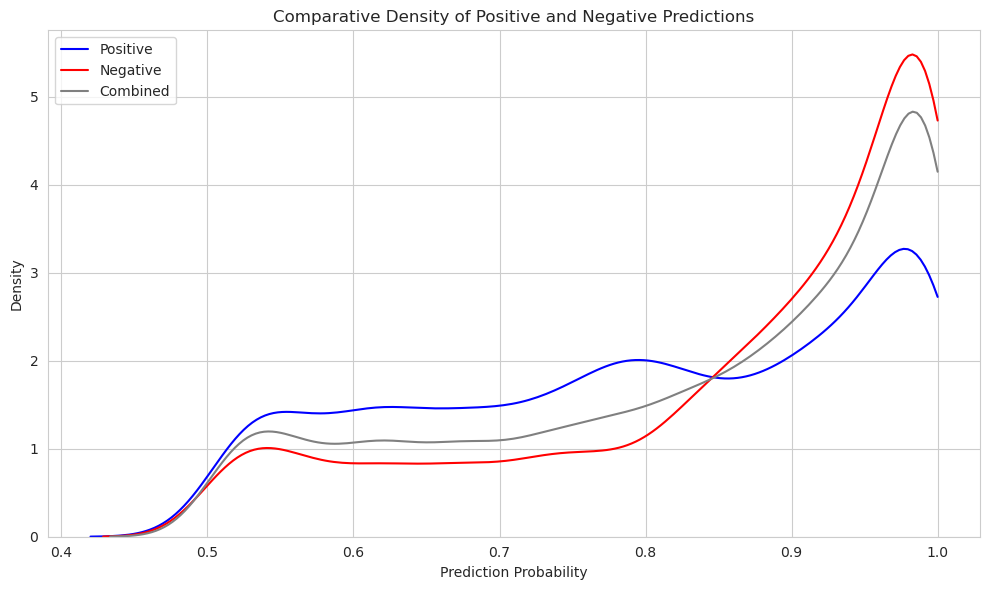

In [34]:
df = pd.read_csv("data/predictions.csv")
# KDE Plot
sns.set_style("whitegrid")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[df['prediction'] == True]['prediction_probability'], fill=False, label='Positive', color="blue", clip=(0, 1))
    sns.kdeplot(df[df['prediction'] == False]['prediction_probability'], fill=False, label='Negative', color="red", clip=(0, 1))
    sns.kdeplot(df['prediction_probability'], fill=False, label='Combined', color='grey', clip=(0, 1))
    plt.xlabel('Prediction Probability')
    plt.ylabel('Density')
    plt.title('Comparative Density of Positive and Negative Predictions')
    plt.legend()

    # Save KDE plot
    plt.tight_layout()


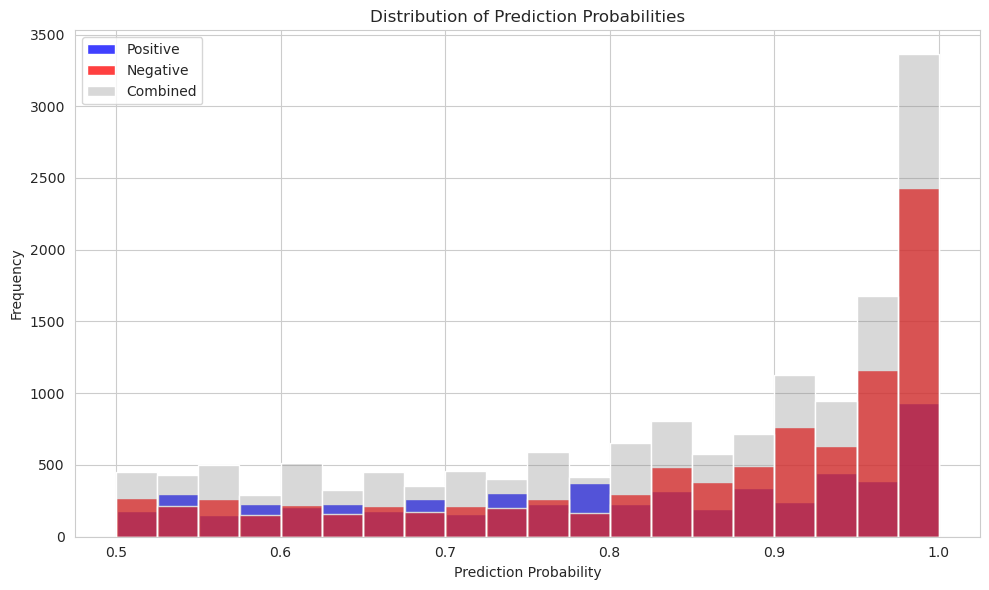

In [35]:
name = os.path.join(output_directory, 'histogram.png')
sns.set_style("whitegrid")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    plt.figure(figsize=(10, 6))
    sns.histplot(df[df['prediction'] == True]['prediction_probability'], kde=False, label='Positive', color="blue", bins=20)
    sns.histplot(df[df['prediction'] == False]['prediction_probability'], kde=False, label='Negative', color="red", bins=20)
    sns.histplot(df['prediction_probability'], kde=False, label='Combined', color='grey', bins=20, alpha=0.3)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend()

    # Save histogram plot
    plt.tight_layout()
    # plt.savefig(name, bbox_inches='tight', dpi=400)     

### 6.2 Extra analyses on the discarded datasets

#### FInding out information of the discarded with low probability

In [36]:
discarded = pd.read_csv("data/discarded.csv")

features =['id','length', 'jumbophage', 'gc_perc', 'CDS', 'frame_positive',
       'frame_negative', 'cds_coding_density', 'positive_strand_%',
       'negative_strand_%', 'CARD_AMR_Genes', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'transl_table']


discarded = discarded[features]
print(discarded.shape)
discarded.head()

(15047, 33)


,id,genome_length_inphared,gc_%_inphared,cds_number_inphared,positive_strand_%_inphared,negative_strand_%_inphared,coding_capacity_inphared,tRNAs_inphared,cds_coding_density,jumbophage_inphared,...,tail,tmRNAs,transcription,unkown_function,frame_positive,frame_negative,molecule_inphared_type_DNA,molecule_inphared_type_ss-DNA,molecule_inphared_type_RNA,molecule_inphared_type_ss-RNA
0,GU339467,53332.0,64.530,90.0,40.000000,60.000000,90.416635,1.0,90.11,0.0,...,13.0,0.0,3.0,44.0,36.0,54.0,True,False,False,False
1,MF417929,32618.0,39.218,42.0,16.666667,83.333333,89.416886,0.0,89.29,0.0,...,10.0,0.0,1.0,17.0,7.0,35.0,True,False,False,False
2,MH616963,94878.0,28.507,89.0,56.179775,43.820225,94.964059,2.0,94.70,0.0,...,1.0,0.0,0.0,74.0,50.0,39.0,True,False,False,False
3,MH552500,90023.0,29.180,86.0,47.674419,52.325581,92.927363,2.0,92.83,0.0,...,0.0,0.0,0.0,72.0,41.0,46.0,True,False,False,False
4,BK010471,97065.0,29.274,91.0,50.549451,49.450549,94.458353,0.0,94.52,0.0,...,2.0,0.0,0.0,74.0,47.0,45.0,True,False,False,False


In [37]:
df = pd.read_csv("data/predictions.csv")


In [38]:
# Filter the DataFrame where prediction_probability is below 0.85
filtered_df = df[df['prediction_probability'] < 0.80]

# Extract the 'id' values as a list
id_list = filtered_df['id'].tolist()

discarded = discarded[discarded['id'].isin(id_list)]
print(discarded.shape)
discarded

(5183, 33)


,id,genome_length_inphared,gc_%_inphared,cds_number_inphared,positive_strand_%_inphared,negative_strand_%_inphared,coding_capacity_inphared,tRNAs_inphared,cds_coding_density,jumbophage_inphared,...,tail,tmRNAs,transcription,unkown_function,frame_positive,frame_negative,molecule_inphared_type_DNA,molecule_inphared_type_ss-DNA,molecule_inphared_type_RNA,molecule_inphared_type_ss-RNA
1,MF417929,32618.0,39.218,42.0,16.666667,83.333333,89.416886,0.0,89.29,0.0,...,10.0,0.0,1.0,17.0,7.0,35.0,True,False,False,False
5,AC171169,104373.0,38.783,146.0,28.767123,71.232877,89.145660,6.0,89.14,0.0,...,14.0,0.0,3.0,60.0,42.0,106.0,True,False,False,False
8,KT997847,33961.0,32.384,47.0,100.000000,0.000000,91.555019,1.0,92.18,0.0,...,3.0,0.0,0.0,25.0,48.0,0.0,True,False,False,False
22,LR756508,484177.0,39.553,683.0,98.389458,1.610542,89.636022,31.0,88.99,1.0,...,11.0,1.0,1.0,557.0,674.0,12.0,True,False,False,False
25,LR756502,642428.0,31.472,971.0,54.582904,45.417096,94.525145,45.0,93.96,1.0,...,9.0,0.0,5.0,819.0,531.0,441.0,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15022,OM869688,2052.0,55.361,2.0,0.000000,100.000000,81.432749,0.0,82.36,0.0,...,0.0,0.0,0.0,2.0,0.0,2.0,True,False,False,False
15023,NC_048848,31118.0,46.944,51.0,96.078431,3.921569,93.592133,0.0,93.43,0.0,...,5.0,0.0,1.0,28.0,49.0,2.0,True,False,False,False
15024,NC_002515,11660.0,26.792,11.0,45.454545,54.545455,91.080617,0.0,93.11,0.0,...,0.0,0.0,0.0,9.0,6.0,6.0,True,False,False,False
15044,MN882550,31118.0,46.944,51.0,96.078431,3.921569,93.592133,0.0,93.43,0.0,...,5.0,0.0,1.0,28.0,49.0,2.0,True,False,False,False


In [39]:
discarded = discarded[['genome_length_inphared','gc_%_inphared', 'cds_number_inphared',
          'cds_coding_density', 'positive_strand_%_inphared', 'connector',
          'tail', 'unkown_function', 'lysis','nucleotide_metabolism',
]]

stats = discarded.describe(percentiles=[0.5])
stats = stats.transpose()
stats = stats[['mean', 'std', 'min', '50%', 'max']]
stats = stats.round(2)
stats

,mean,std,min,50%,max
genome_length_inphared,60873.81,44768.81,2052.00,49098.00,642428.00
gc_%_inphared,52.25,13.08,22.07,54.68,72.69
cds_number_inphared,90.47,67.00,2.00,73.00,971.00
cds_coding_density,90.98,4.19,24.41,91.64,102.48
positive_strand_%_inphared,76.70,25.52,0.00,86.90,100.00
connector,2.41,1.55,0.00,2.00,11.00
tail,7.29,3.82,0.00,7.00,47.00
unkown_function,55.88,53.40,0.00,39.00,819.00
lysis,2.20,1.23,0.00,2.00,9.00
nucleotide_metabolism,10.03,7.48,0.00,8.00,64.00


Comparing the positives and negatives from the labeled dataset with the predicted data below 0.8

In [40]:
discarded = discarded[['genome_length_inphared','gc_%_inphared', 'cds_number_inphared',
          'cds_coding_density', 'positive_strand_%_inphared', 'connector',
          'tail', 'unkown_function', 'lysis','nucleotide_metabolism',
]]
discarded['staining'] = 3
discarded.columns

Index(['genome_length_inphared', 'gc_%_inphared', 'cds_number_inphared',
       'cds_coding_density', 'positive_strand_%_inphared', 'connector', 'tail',
       'unkown_function', 'lysis', 'nucleotide_metabolism', 'staining'],
      dtype='object')

In [41]:
df = pd.read_csv("data/features_with_gram_class.csv")

df = df[['staining','genome_length_inphared','gc_%_inphared', 'cds_number_inphared',
          'cds_coding_density', 'positive_strand_%_inphared', 'connector',
          'tail', 'unkown_function', 'lysis','nucleotide_metabolism',
]]
df['staining'] = df['staining'].replace({'negative': 0, 'positive': 1})

df.columns

Index(['staining', 'genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'cds_coding_density',
       'positive_strand_%_inphared', 'connector', 'tail', 'unkown_function',
       'lysis', 'nucleotide_metabolism'],
      dtype='object')

In [42]:
df = pd.concat([df, discarded], ignore_index=True)


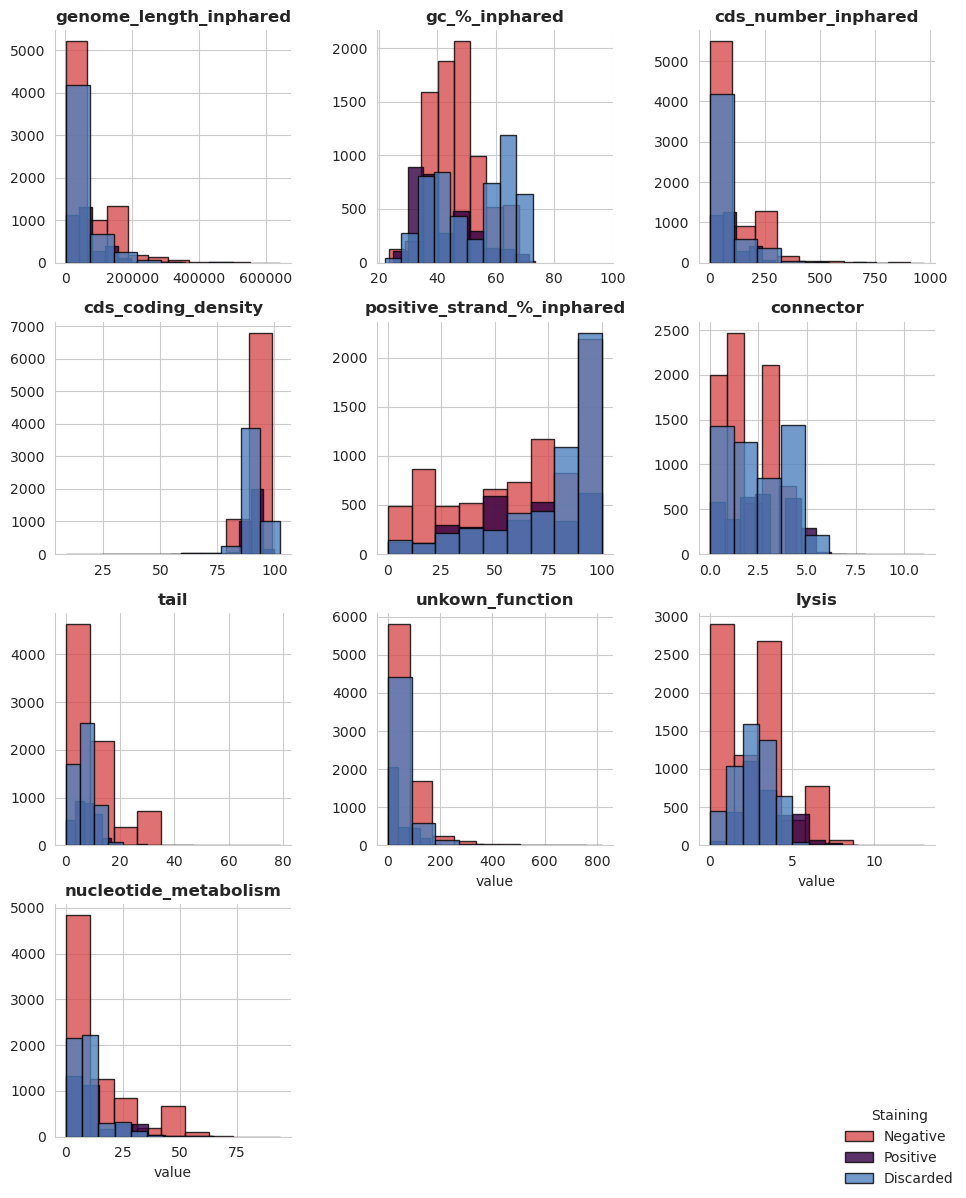

In [43]:

# First, melt the DataFrame
df_melted = pd.melt(df, id_vars='staining', value_vars=['genome_length_inphared', 'gc_%_inphared',
                                                         'cds_number_inphared', 'cds_coding_density',
                                                         'positive_strand_%_inphared', 'connector',
                                                         'tail', 'unkown_function', 'lysis',
                                                         'nucleotide_metabolism'],
                    var_name='variable', value_name='value')

# Update the color palette to include the new 'staining' value
palette = {0: '#D74D4F', 1: '#330043', 3: '#4F81BD'}  # Red for 0, Purple for 1, Blue for 3

# Set up the FacetGrid with 3 columns per row, no shared x/y axes, and space between subplots
g = sns.FacetGrid(df_melted, col="variable", hue="staining", palette=palette, col_wrap=3, sharex=False, sharey=False)

# Define the plotting function with an alpha value and individual bin calculation
def custom_hist(x, color, label, **kwargs):
    bins = np.linspace(min(x), max(x), 10)  # Calculate bins based on the data in 'x'
    plt.hist(x, bins=bins, color=color, label=label, alpha=0.8, **kwargs)

# Map the histograms to the grid using the custom_hist function
g.map(custom_hist, 'value', ec="k")

# Add a legend with specified placement
g.add_legend(title='Staining', loc='lower right')

# Modify the legend labels (adapt this to match the 'staining' values in your dataset)
new_labels = ["Negative", "Positive", "Discarded"]
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Set the title for each subplot to the name of the variable and make it bold
for ax, title in zip(g.axes.flatten(), g.col_names):
    ax.set_title(title, fontweight='bold')
    # Modify x-axis ticks for 'gc_%_inphared'
    if title == 'gc_%_inphared':
        ax.set_xticks([20, 40, 60, 80, 100])

# Adjust the layout
g.fig.tight_layout(w_pad=2)

output_directory = "../reports/figures/"
name = os.path.join(output_directory, '1_barplot_combined_discarded.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  